In [6]:
# @title [Stop] 0. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH (Sử dụng Dual ControlNet)
# ... (các dòng import khác)

print("--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---")

# 1. Cài đặt thư viện (Bao gồm xformers và chỉ định phiên bản cũ hơn của controlnet_aux)
!pip install diffusers transformers accelerate xformers
!pip install controlnet_aux  # Cài đặt phiên bản ổn định đã được kiểm chứng
# ...

--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 128.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.

In [ ]:
# @title [Stop] 3. TẠO ẢNH NỀN CỐ ĐỊNH BẰNG AI VÀ TRÍCH XUẤT DEPTH MAP

# Cần đảm bảo Cell 1 đã chạy và có biến 'pipe' (StableDiffusionPipeline) và 'depth_detector'
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt

# --- 1. PROMPT TẠO ẢNH NỀN LÝ TƯỞNG ---
# Prompt phải mô tả một bối cảnh cố định, không có nhân vật
BACKGROUND_PROMPT = "minimalist modern office background, clean desk, one dark executive chair slightly pushed back, large window with soft sunlight, smooth polished floor, high quality, cinematic lighting, centered"
NEG_BG_PROMPT = "person, people, blurry, low resolution, worst quality, out of focus, cartoon, illustration"
BG_SEED = 12345 # Dùng seed cố định để đảm bảo bối cảnh luôn giống nhau

BG_DEPTH_MAP = None

print("--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---")

try:
    # 2. TẠO ẢNH NỀN BẰNG T2I
    generator_bg = torch.Generator(device).manual_seed(BG_SEED)

    # Sử dụng pipeline T2I đã tải ở Cell 1
    BG_IMAGE = pipe(
        prompt=BACKGROUND_PROMPT,
        negative_prompt=NEG_BG_PROMPT,
        num_inference_steps=50,
        guidance_scale=8.0,
        generator=generator_bg,
        height=768,
        width=768
    ).images[0]

    BG_IMAGE_PATH = os.path.join(os.environ['OUTPUT_DIR'], "AI_Generated_Background.png")
    BG_IMAGE.save(BG_IMAGE_PATH)
    print(f"-> Đã tạo và lưu ảnh nền cố định bằng AI tại: {BG_IMAGE_PATH}")

    # 3. TRÍCH XUẤT DEPTH MAP TỪ ẢNH NỀN ĐÃ TẠO
    # Sử dụng depth_detector đã tải ở Cell 1
    globals()['BG_DEPTH_MAP'] = depth_detector(BG_IMAGE)
    print("-> Đã trích xuất Depth Map cho bối cảnh thành công.")

    # 4. HIỂN THỊ KIỂM TRA
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(BG_IMAGE); axes[0].set_title("1. Ảnh Nền AI Gốc", fontsize=10); axes[0].axis('off')
    axes[1].imshow(globals()['BG_DEPTH_MAP'], cmap='gray'); axes[1].set_title("2. Depth Map (Control Map cho Bối cảnh)", fontsize=10); axes[1].axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"!!! LỖI TẠO HOẶC XỬ LÝ ẢNH NỀN AI: {e}")
    print("Sử dụng Depth Map trung tính để tránh lỗi runtime.")
    globals()['BG_DEPTH_MAP'] = Image.new('RGB', (768, 768), color = 'white') # Fallback an toàn

print("\n--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ AI ---")


In [ ]:
# @title [Stop] 4. SẢN XUẤT ẢNH BẰNG DUAL CONTROLNET (POSE + DEPTH)

# --- CẤU HÌNH VÀ TẢI PIPELINE PHỨC HỢP ---
try:
    # 1. Tải ControlNet Model (Pose)
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)

    # 2. Tải ControlNet Model (Depth)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # 3. Tạo Pipeline với LIST ControlNet
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet] # LIST ControlNet Models
    ).to(device)
    if device == "cuda":
        i2i_pipe.enable_xformers_memory_efficient_attention()
    print("Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")

except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None


# --- DANH SÁCH CÁC CẶP FILE VÀ PROMPT CỦA CHÚNG (Lấy từ Cell 2) ---
# TẠO 4 ẢNH ĐỂ TEST CÁC TƯ THẾ KHÁC NHAU
PROMPT_MAP_FULL = [
    # Cần đảm bảo các file OpenPose này tồn tại!
    ("NU_1_Action_Uniform_V2_openpose.png", "NU", "hands on hips, torso leaning forward aggressively, challenging body language"),
    ("NAM_2_Action_Uniform_V2_openpose.png", "NAM", "hands deeply set in pants pockets, shoulders slightly hunched, head tilted, defensive posture"),
    ("NU_3_Action_Uniform_V2_openpose.png", "NU", "arms tightly crossed over chest, legs crossed, torso turned slightly away, rejecting body language"),
    ("NAM_4_Action_Uniform_V2_openpose.png", "NAM", "both palms turned outward in a gesture of honesty, feet shoulder-width apart, pleading body posture"),
]

# Style Prompt Đồng Nhất
CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, minimal office setting, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, minimal office setting, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects" # Furniture bị loại bỏ bởi ControlNet Depth

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(OUTPUT_DIR, pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"

        generator = torch.Generator(device).manual_seed(100 + i)

        # --- GỌI DUAL CONTROLNET ---
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=ref_image,
            control_image=[pose_image, globals()['BG_DEPTH_MAP']], # LIST Control Maps
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,
            controlnet_conditioning_scale=[1.0, 1.5], # Pose: Mạnh (1.0), Depth: Vừa phải (0.8)
            strength=0.7, # Buộc thay đổi tư thế, giữ nhân vật
            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ HIỂN THỊ ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(CONSISTENCY_DIR, output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")
r
    print("\n--- HOÀN TẤT VIỆC TẠO ẢNH SẢN XUẤT ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")



Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).

BẮT ĐẦU TẠO 4 ẢNH VỚI DUAL CONTROLNET...


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_1_NU_FINAL_IMAGE.png


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_2_NAM_FINAL_IMAGE.png

--- HOÀN TẤT VIỆC TẠO ẢNH SẢN XUẤT ---


In [ ]:
# @title 0. Tiện Ích Đồ Họa
import matplotlib.pyplot as plt

def plot_image_in_subplot(image, title, position, rows=1, cols=2):
    """Vẽ một ảnh vào subplot."""
    plt.subplot(rows, cols, position)
    plt.imshow(image)
    plt.title(title, fontsize=10)
    plt.axis('off')

def show_images(base_image, pose_image, file_prefix, figsize=(7.0, 3.5)):
    """Hiển thị Ảnh Gốc và OpenPose Map cạnh nhau với kích thước nhỏ (~160px)."""
    print(f"--- HIỂN THỊ KẾT QUẢ NẰM NGANG {file_prefix} ---")

    plt.figure(figsize=figsize)

    # 1. Vẽ Ảnh Gốc
    plot_image_in_subplot(base_image, f"1. Ảnh Gốc ({file_prefix})", 1)

    # 2. Vẽ OpenPose Map
    plot_image_in_subplot(pose_image, f"2. OpenPose Map ({file_prefix})", 2)

    plt.tight_layout()
    plt.show()
    print("-" * 30)

# Lưu ý: Các hàm này phải được chạy trước khi gọi ở Cell 2.

In [1]:
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH (SETUP VỚI TRANSFORMERS DEPTH)

import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline # Thêm import cho pipeline

print("--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---")

# 1. Cài đặt thư viện
!pip install diffusers transformers accelerate opencv-python-headless xformers
!pip install controlnet_aux --upgrade

# 2. Tải các thư viện Python
from diffusers import StableDiffusionPipeline, ControlNetModel, StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler
# Chỉ import các Preprocessor cần thiết từ controlnet_aux (KHÔNG CÓ MIDAS/Depth)
from controlnet_aux.open_pose import OpenposeDetector
from controlnet_aux.canny import CannyDetector


# 3. Thiết lập thư mục đầu ra
OUTPUT_DIR = "Pro_Auto_Pose_Output"
CONSISTENCY_DIR = "Pro_Consistency_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CONSISTENCY_DIR, exist_ok=True)
os.environ['OUTPUT_DIR'] = OUTPUT_DIR
os.environ['CONSISTENCY_DIR'] = CONSISTENCY_DIR


# 4. Kiểm tra GPU và thiết lập Device
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache()
print(f"Thiết bị đang sử dụng: {device}")


# 5. Tải BASE Stable Diffusion Pipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Kích hoạt Xformers
if device == "cuda":
    try:
        pipe.enable_xformers_memory_efficient_attention()
        print("Đã kích hoạt tối ưu hóa xformers cho Base Pipeline.")
    except Exception:
        print("CẢNH BÁO: Không thể kích hoạt xformers.")


# 6. Tải Preprocessor (ControlNet Aux)
openpose_detector = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)
canny_detector = CannyDetector()

# KHÔNG CÓ depth_detector TRONG CELL NÀY

print("Đã tải tất cả Preprocessor (OpenPose, Canny).")


print("\n--- HOÀN TẤT CELL 1: SẴN SÀNG CHUYỂN SANG CELL 2 ---")


--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---
Thiết bị đang sử dụng: cuda


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Đã kích hoạt tối ưu hóa xformers cho Base Pipeline.


annotator/ckpts/body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

annotator/ckpts/hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

Đã tải tất cả Preprocessor (OpenPose, Canny).

--- HOÀN TẤT CELL 1: SẴN SÀNG CHUYỂN SANG CELL 2 ---


In [ ]:
# @title 2. TẠO ẢNH THAM CHIẾU VÀ TRÍCH XUẤT OPENPOSE (Mô phỏng Cell 2)
import matplotlib.pyplot as plt
# --- CẤU HÌNH PROMPT GỐC ---
PROMPT_MAP = [
    (f"NU_1_Action_Uniform_V2", "NU", "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, clean modern studio background, hands on hips, torso leaning forward aggressively, challenging body language"),
    (f"NAM_2_Action_Uniform_V2", "NAM", "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, clean modern studio background, hands deeply set in pants pockets, shoulders slightly hunched, head tilted, defensive posture"),
    # (Thêm 8 cặp còn lại ở đây, nhưng chỉ cần chạy 2 cặp đầu để test nhanh)
    (f"NU_3_Action_Uniform_V2", "NU", "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, clean modern studio background, arms tightly crossed over chest, legs crossed, rejecting body language"),
    (f"NAM_4_Action_Uniform_V2", "NAM", "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, clean modern studio background, both palms turned outward in a gesture of honesty, pleading body posture"),
    # ... (Các tư thế khác)
]
# Giới hạn chỉ tạo 2 ảnh tham chiếu để test nhanh
PROMPT_MAP_LITE = PROMPT_MAP[:2]

NEG_PROMPT = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, furniture"
generator = torch.Generator(device).manual_seed(42)

print(f"BẮT ĐẦU TẠO {len(PROMPT_MAP_LITE)} ẢNH THAM CHIẾU GỐC VÀ OPENPOSE MAP...")

# --- THỰC HIỆN T2I ĐỂ TẠO ẢNH GỐC & TRÍCH XUẤT MAP ---
for file_prefix, gender, full_prompt in PROMPT_MAP_LITE:
    # 1. Tạo ảnh Gốc (Base Image)
    base_image = pipe(
        prompt=full_prompt,
        negative_prompt=NEG_PROMPT,
        num_inference_steps=50,
        guidance_scale=9.0,
        generator=generator,
        height=768, width=768
    ).images[0]

    # 2. Trích xuất OpenPose Map
    pose_image = openpose_detector(base_image)

    # 3. Lưu ảnh và Map
    base_image_path = os.path.join(OUTPUT_DIR, f"{file_prefix}_base_image.png")
    pose_image_path = os.path.join(OUTPUT_DIR, f"{file_prefix}_openpose.png")
    base_image.save(base_image_path)
    pose_image.save(pose_image_path)
    print(f"-> Đã tạo và lưu Base Image & Pose Map cho {file_prefix}")

    show_images(base_image, pose_image, file_prefix);

# --- TẢI 2 ẢNH THAM CHIẾU LÀM BIẾN TOÀN CỤC ---
try:
    REF_NU_PATH = os.path.join(OUTPUT_DIR, "NU_1_Action_Uniform_V2_base_image.png")
    REF_NAM_PATH = os.path.join(OUTPUT_DIR, "NAM_2_Action_Uniform_V2_base_image.png")

    globals()['REF_NU_IMAGE'] = Image.open(REF_NU_PATH).resize((768, 768)).convert("RGB")
    globals()['REF_NAM_IMAGE'] = Image.open(REF_NAM_PATH).resize((768, 768)).convert("RGB")
except Exception:
    print("!!! LỖI: Không tìm thấy ảnh tham chiếu. Kiểm tra lại việc tạo ảnh.")
    globals()['REF_NU_IMAGE'] = Image.new('RGB', (768, 768), color = 'black')
    globals()['REF_NAM_IMAGE'] = Image.new('RGB', (768, 768), color = 'black')

print("\n--- HOÀN TẤT CELL 2: ĐÃ CÓ ẢNH THAM CHIẾU VÀ OPENPOSE MAP ---")


BẮT ĐẦU TẠO 2 ẢNH THAM CHIẾU GỐC VÀ OPENPOSE MAP...


  0%|          | 0/50 [00:00<?, ?it/s]

-> Đã tạo và lưu Base Image & Pose Map cho NU_1_Action_Uniform_V2


NameError: name 'show_images' is not defined

--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---


  0%|          | 0/50 [00:00<?, ?it/s]

No model was supplied, defaulted to Intel/dpt-large and revision bc15f29 (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.


-> Đã tạo và lưu ảnh nền cố định bằng AI tại: Pro_Auto_Pose_Output/AI_Generated_Background.png
-> Đang trích xuất Depth Map bằng 'depth-estimation' pipeline...


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


-> Đã trích xuất và chuẩn hóa Depth Map thành công.


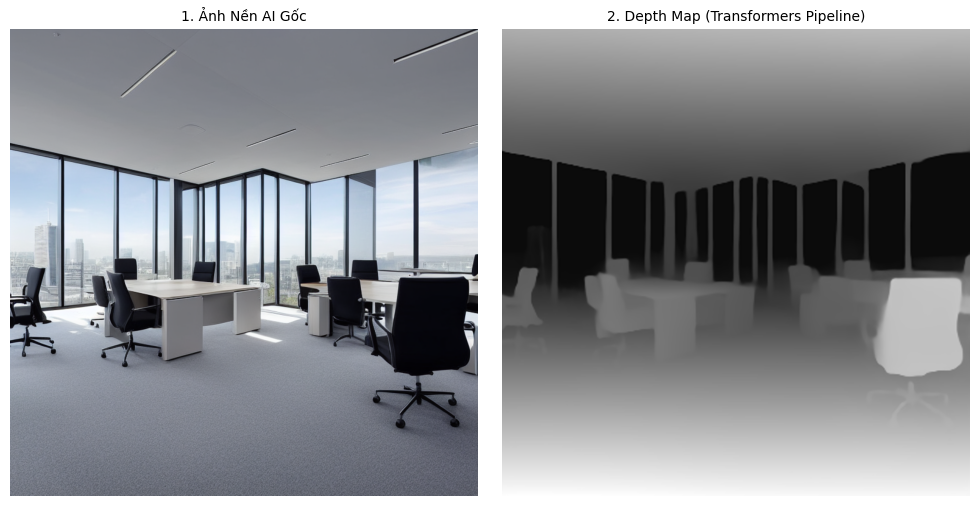


--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ TRANSFORMERS ---


In [ ]:
# @title 3. TẠO ẢNH NỀN CỐ ĐỊNH BẰNG AI VÀ TRÍCH XUẤT DEPTH MAP (Sử dụng TRANSFORMERS)

# --- 1. CẤU HÌNH PROMPT TẠO ẢNH NỀN ---
BACKGROUND_PROMPT = "minimalist modern corporate office background, clean desk, executive chair, large window with soft sunlight, smooth polished floor, no visible person, centered composition, high quality"
NEG_BG_PROMPT = "person, people, blurry, low resolution, worst quality, out of focus, cartoon, illustration, cluttered"
BG_SEED = 12345

BG_DEPTH_MAP = None
print("--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---")

try:
    # 2. TẠO ẢNH NỀN BẰNG T2I (Dùng 'pipe' từ Cell 1)
    generator_bg = torch.Generator(device).manual_seed(BG_SEED)

    BG_IMAGE = pipe(
        prompt=BACKGROUND_PROMPT,
        negative_prompt=NEG_BG_PROMPT,
        num_inference_steps=50,
        guidance_scale=8.0,
        generator=generator_bg,
        height=768,
        width=768
    ).images[0]

    BG_IMAGE_PATH = os.path.join(os.environ['OUTPUT_DIR'], "AI_Generated_Background.png")
    BG_IMAGE.save(BG_IMAGE_PATH)
    print(f"-> Đã tạo và lưu ảnh nền cố định bằng AI tại: {BG_IMAGE_PATH}")

    # 3. TRÍCH XUẤT DEPTH MAP BẰNG TRANSFORMERS PIPELINE (FIX MỚI)
    print("-> Đang trích xuất Depth Map bằng 'depth-estimation' pipeline...")

    # Khởi tạo Depth Pipeline của Transformers (chỉ trong Cell này)
    depth_estimator_pipeline = pipeline('depth-estimation', device=device)

    # Trích xuất Depth Map
    depth_result = depth_estimator_pipeline(BG_IMAGE)['depth']

    # Chuẩn hóa Depth Map để ControlNet có thể sử dụng (0-255 RGB)
    image_np = np.array(depth_result)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_np = (image_np * 255).astype(np.uint8)

    # Chuyển đổi sang 3 kênh (ControlNet cần RGB)
    image_np = image_np[:, :, None]
    image_np = np.concatenate([image_np, image_np, image_np], axis=2)

    globals()['BG_DEPTH_MAP'] = Image.fromarray(image_np)
    print("-> Đã trích xuất và chuẩn hóa Depth Map thành công.")

    # 4. HIỂN THỊ KIỂM TRA
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(BG_IMAGE); axes[0].set_title("1. Ảnh Nền AI Gốc", fontsize=10); axes[0].axis('off')
    axes[1].imshow(globals()['BG_DEPTH_MAP'], cmap='gray'); axes[1].set_title("2. Depth Map (Transformers Pipeline)", fontsize=10); axes[1].axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"!!! LỖI TẠO HOẶC XỬ LÝ ẢNH NỀN AI BẰNG TRANSFORMERS: {e}. Sử dụng Depth Map trung tính.")
    globals()['BG_DEPTH_MAP'] = Image.new('RGB', (768, 768), color = 'white')

print("\n--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ TRANSFORMERS ---")


In [ ]:
# @title 4a. Khởi Tạo DUAL ControlNet Pipeline (Tách biệt Output Dài)
import torch
# Giả định: ControlNetModel, StableDiffusionImg2ImgPipeline, device, model_id đã được import.

# --- KHỞI TẠO PIPELINE ---
try:
    print("Đang tải các mô hình ControlNet...")
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # Tải lại Pipeline DUAL ControlNet
    # LƯU Ý: Đây là đoạn code sinh ra output dài, nó sẽ kết thúc tại đây.
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet]
    ).to(device)

    if device == "cuda":
        i2i_pipe.enable_xformers_memory_efficient_attention()

    print("\n" * 3) # THÊM KHOẢNG TRỐNG ĐỂ NGẮT THÔNG BÁO DÀI
    print("✅ Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")

except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None

Đang tải các mô hình ControlNet...


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/945 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]





✅ Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).


Mask meta: {'kernel': 71, 'percent': np.float64(0.24359130859375), 'final_percent': np.float64(0.2586127387152778)}


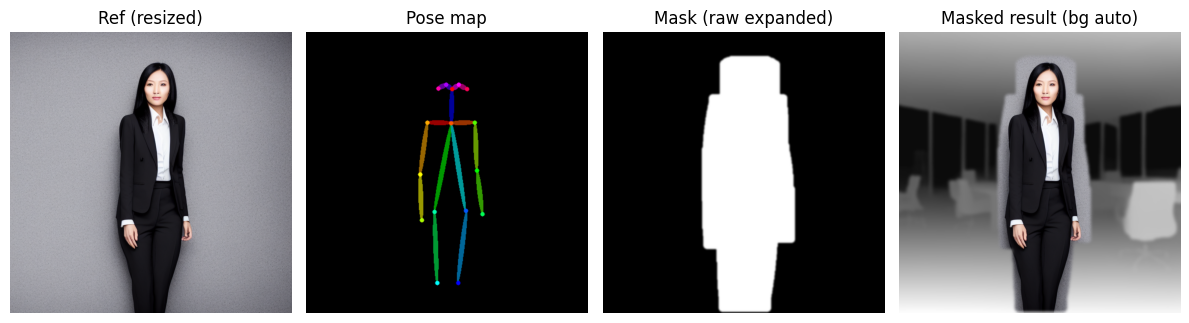

Saved debug images to CONSISTENCY_DIR


In [ ]:
# @title 4b. Xử Lý, Masking

# Cell: improved_mask_and_composite.py
import os
import numpy as np
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt

# Try import cv2 for stronger morphology
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

def _sample_border_color(img_pil, sample_frac=0.05):
    """Estimate background color by sampling border pixels (returns (r,g,b))."""
    w, h = img_pil.size
    img = np.array(img_pil.convert("RGB"))
    pad_w = max(1, int(w * sample_frac))
    pad_h = max(1, int(h * sample_frac))
    # sample top, bottom, left, right strips
    strips = []
    strips.append(img[:pad_h, :, :].reshape(-1,3))
    strips.append(img[-pad_h:, :, :].reshape(-1,3))
    strips.append(img[:, :pad_w, :].reshape(-1,3))
    strips.append(img[:, -pad_w:, :].reshape(-1,3))
    stacked = np.concatenate(strips, axis=0)
    med = np.median(stacked, axis=0).astype(int)
    # slightly desaturate / brighten to be neutral
    med = np.clip(med * np.array([1.02,1.02,1.02]), 0, 255).astype(int)
    return tuple(med.tolist())

def expand_mask_cv2(mask_np, kernel_size, iterations=1, blur_radius=3, thresh_after=64, vertical_ratio=2.0):
    """Use cv2.dilate + optional blur to expand; supports vertical elongation."""
    h_kernel = int(kernel_size)
    v_kernel = int(kernel_size * vertical_ratio)
    kernel = np.ones((v_kernel, h_kernel), np.uint8)  # vertical stretched kernel
    dil = cv2.dilate(mask_np, kernel, iterations=iterations)
    if blur_radius and blur_radius > 0:
        dil = cv2.GaussianBlur(dil, (blur_radius * 2 + 1, blur_radius * 2 + 1), 0)
        _, dil = cv2.threshold(dil, thresh_after, 255, cv2.THRESH_BINARY)
    return dil


def expand_mask_pil(mask_img, expand_size=21, soften_radius=3):
    """Fallback method using PIL MaxFilter repeated to simulate dilation."""
    out = mask_img
    n = max(1, int(expand_size // 3))
    for _ in range(n):
        out = out.filter(ImageFilter.MaxFilter(3))
    if soften_radius and soften_radius>0:
        out = out.filter(ImageFilter.GaussianBlur(radius=soften_radius))
        arr = np.array(out)
        out = Image.fromarray(((arr>64).astype('uint8')*255)).convert("L")
    return out

def make_fullbody_mask_from_pose(pose_path, target_size=(768,768),
                                 method='auto', expand_start=21, expand_step=10,
                                 max_expand=81, blur_radius=3, min_percent=0.20):
    """
    Create a full-body mask from a skeleton/pose map by iteratively expanding
    until at least min_percent of image is covered or max_expand reached.
    Returns PIL L mask (0/255) and metadata.
    """
    pose = Image.open(pose_path).convert("RGB").resize(target_size, Image.NEAREST)
    gray = pose.convert("L")
    arr = np.array(gray)

    # initial tiny threshold to capture skeleton lines
    init = (arr > 6).astype('uint8') * 255
    init_img = Image.fromarray(init).convert("L")

    if method == 'auto':
        method = 'cv2' if HAS_CV2 else 'pil'

    best_mask = None
    best_meta = {}
    # iterate expanding kernel sizes
    for k in range(expand_start, max_expand + 1, expand_step):
        if method == 'cv2' and HAS_CV2:
            mask_np = expand_mask_cv2(init, kernel_size=k, iterations=1, blur_radius=blur_radius, thresh_after=64)
            mask_img = Image.fromarray(mask_np).convert("L")
        else:
            mask_img = expand_mask_pil(init_img, expand_size=k, soften_radius=blur_radius)

        percent = (np.array(mask_img) > 0).mean()
        best_mask = mask_img
        best_meta = {'kernel': k, 'percent': percent}
        # stop if reached target percent of the image
        if percent >= min_percent:
            break

    # do a final gentle gaussian blur to soften edges and keep mask as L (with soft edges)
    soft = best_mask.filter(ImageFilter.GaussianBlur(radius=2))
    # ensure values in 0..255 (PIL L)
    final_arr = np.array(soft)
    # normalize to 0..255
    final = Image.fromarray(((final_arr/ final_arr.max())*255).astype('uint8')) if final_arr.max()>0 else best_mask
    final = final.convert("L")
    best_meta['final_percent'] = (np.array(final)>0).mean()
    return final, best_meta

def create_masked_ref_image_refined(ref_image, pose_image_path, target_size=(768,768),
                                    bg_mode='auto', bg_color=None,
                                    method='auto', expand_start=21, expand_step=10,
                                    max_expand=81, blur_radius=3, min_percent=0.22,
                                    debug=False, save_prefix='debug_mask'):
    """
    Returns masked PIL RGB image (person preserved, background replaced).
    bg_mode: 'auto' (pick good bg color), 'color' (use bg_color), 'blur_depth' (if BG_DEPTH_MAP exists)
    If debug True returns (masked, mask_img, meta)
    """
    ref_resized = ref_image.convert("RGB").resize(target_size, Image.LANCZOS)

    # make mask
    mask_img, meta = make_fullbody_mask_from_pose(pose_image_path, target_size=target_size,
                                                  method=method, expand_start=expand_start,
                                                  expand_step=expand_step, max_expand=max_expand,
                                                  blur_radius=blur_radius, min_percent=min_percent)

    # pick background
    if bg_mode == 'color':
        if bg_color is None:
            bg_color = (230,230,230)  # soft light gray
        bg = Image.new("RGB", target_size, bg_color)
    elif bg_mode == 'blur_depth' and 'BG_DEPTH_MAP' in globals():
        # try to use BG_DEPTH_MAP as source background, blur it
        depth = globals()['BG_DEPTH_MAP']
        if isinstance(depth, np.ndarray):
            bg_img = Image.fromarray((depth*255).astype('uint8')) if depth.max()<=1.0 else Image.fromarray(depth.astype('uint8'))
        else:
            bg_img = depth
        bg = bg_img.convert("RGB").resize(target_size, Image.BILINEAR).filter(ImageFilter.GaussianBlur(radius=4))
    else:
        # auto: sample border color and make a slightly brighter/desaturated version or gradient
        sample_color = _sample_border_color(ref_resized)
        # lighten slightly
        bg = Image.new("RGB", target_size, tuple(np.clip(np.array(sample_color)+10,0,255).astype(int)))

    # Use softened mask for composite: make an alpha by blurring mask a bit
    alpha = mask_img.filter(ImageFilter.GaussianBlur(radius=3))
    # Ensure alpha is L (0..255)
    alpha = alpha.convert("L")

    # Composite using alpha: PIL.Image.composite expects hard mask, but we can alpha-blend manually
    # convert to arrays and blend: out = ref* (alpha/255) + bg*(1-alpha/255)
    ref_arr = np.array(ref_resized).astype('float32')
    bg_arr = np.array(bg).astype('float32')
    alpha_arr = np.array(alpha).astype('float32')/255.0
    alpha_arr = np.expand_dims(alpha_arr, axis=2)  # HxWx1
    comp = (ref_arr * alpha_arr + bg_arr * (1 - alpha_arr)).astype('uint8')
    masked = Image.fromarray(comp)

    # save debug images if requested
    out_dir = os.environ.get('CONSISTENCY_DIR', '.')
    os.makedirs(out_dir, exist_ok=True)
    masked.save(os.path.join(out_dir, f"{save_prefix}_masked.png"))
    mask_img.save(os.path.join(out_dir, f"{save_prefix}_mask_raw.png"))
    alpha.save(os.path.join(out_dir, f"{save_prefix}_mask_alpha.png"))
    if debug:
        return masked, mask_img, alpha, meta
    return masked

# ------------------- Example usage with your variables -------------------
pose_path = os.path.join(os.environ.get('OUTPUT_DIR','.'), 'NU_1_Action_Uniform_V2_openpose.png')
ref_image = globals().get('REF_NU_IMAGE', None)
if ref_image is None:
    raise RuntimeError("REF_NU_IMAGE not found in globals()")

# Try creating masked image with auto background selection
masked, mask_raw, mask_alpha, meta = create_masked_ref_image_refined(
    ref_image, pose_path, target_size=(768,768),
    bg_mode='blur_depth',      # 'color' or 'blur_depth' (if you have BG_DEPTH_MAP)
    method='auto',       # 'cv2' uses OpenCV if available
    expand_start=51, expand_step=20, max_expand=111,
    blur_radius=3, min_percent=0.22,
    debug=True, save_prefix='test_NU1'
)


# === GÁN BIẾN TOÀN CỤC CHO CELL KHÁC DÙNG ===
MASKED_REF_IMAGE = masked
MASK_RAW_IMAGE = mask_raw
MASK_ALPHA_IMAGE = mask_alpha



print("Mask meta:", meta)
plt.figure(figsize=(12,6))
plt.subplot(1,4,1); plt.imshow(ref_image.convert("RGB").resize((768,768))); plt.title("Ref (resized)"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(Image.open(pose_path).convert("RGB").resize((768,768))); plt.title("Pose map"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(MASK_RAW_IMAGE, cmap='gray'); plt.title("Mask (raw expanded)"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(MASKED_REF_IMAGE); plt.title("Masked result (bg auto)"); plt.axis('off')
plt.tight_layout(); plt.show()

print("Saved debug images to CONSISTENCY_DIR")



BẮT ĐẦU TẠO 2 ẢNH VỚI DUAL CONTROLNET VÀ MASKING...
--- HIỂN THỊ TẠM THỜI: Mask/Depth 1 ---


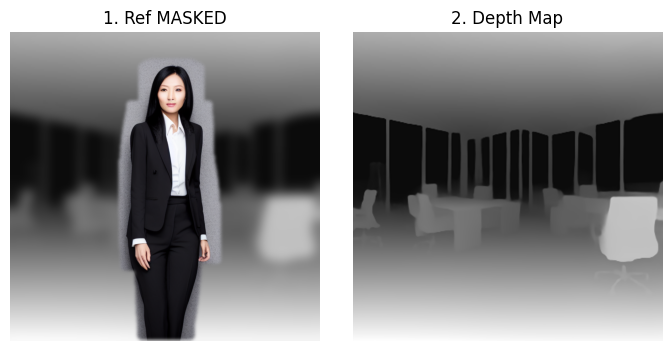

------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_1_NU_FINAL_IMAGE.png
--- HIỂN THỊ TẠM THỜI: Mask/Depth 2 ---


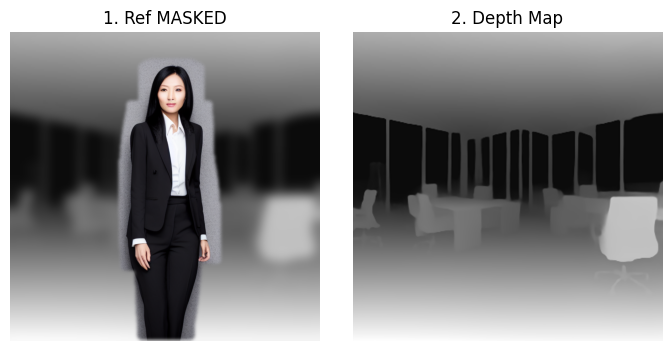

------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_2_NAM_FINAL_IMAGE.png


*** HIỂN THỊ KẾT QUẢ CUỐI CÙNG TỔNG HỢP ***


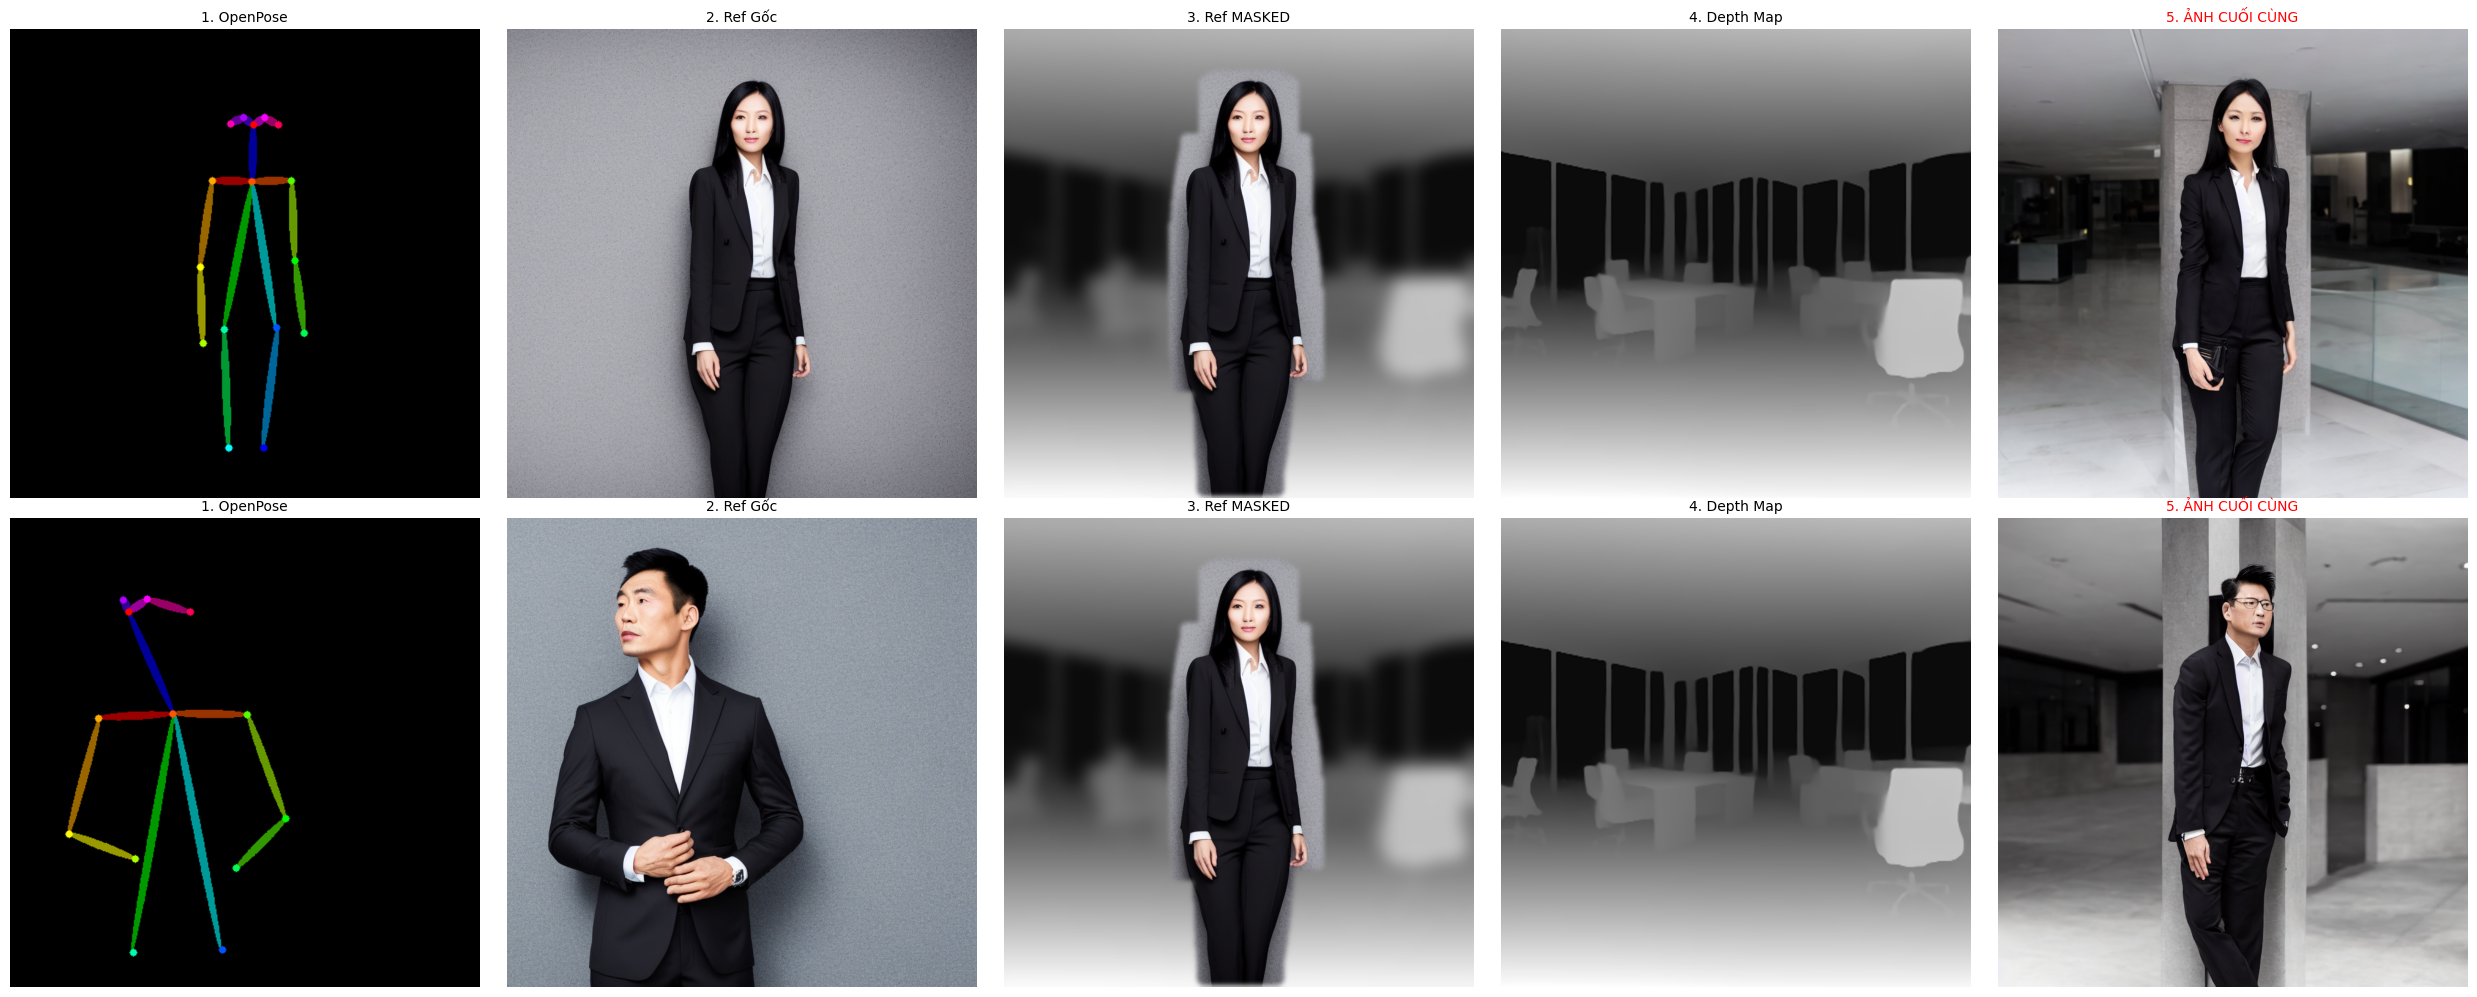


--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---
>>> DEBUG: Kiểm tra biến môi trường và file
OUTPUT_DIR: Pro_Auto_Pose_Output
CONSISTENCY_DIR: Pro_Consistency_Output
i2i_pipe is None? False
torch available, version: 2.8.0+cu126
device var in globals(): True
Files in OUTPUT_DIR (head): ['NAM_2_Action_Uniform_V2_base_image.png', 'NU_1_Action_Uniform_V2_openpose.png', 'NU_1_Action_Uniform_V2_base_image.png', 'NAM_2_Action_Uniform_V2_openpose.png', 'AI_Generated_Background.png']
NU_1_Action_Uniform_V2_openpose.png -> Pro_Auto_Pose_Output/NU_1_Action_Uniform_V2_openpose.png exists? True
NAM_2_Action_Uniform_V2_openpose.png -> Pro_Auto_Pose_Output/NAM_2_Action_Uniform_V2_openpose.png exists? True


In [ ]:
# @title 4c. Xử Lý, Masking và Hiển Thị Kết Quả (Tối ưu hóa)
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# Giả định: globals()['REF_NU_IMAGE'], globals()['REF_NAM_IMAGE'], globals()['BG_DEPTH_MAP'],
# show_images (Cell 0), i2i_pipe (Cell 4a) đã được định nghĩa.


# --- THỰC HIỆN SẢN XUẤT ẢNH ---
PROMPT_MAP_FULL = [
    ("NU_1_Action_Uniform_V2_openpose.png", "NU", "hands on hips, professional posture, full body pose"),
    ("NAM_2_Action_Uniform_V2_openpose.png", "NAM", "hands deeply set in pants pockets, head tilted, defensive posture"),
]


CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects, text, logos"

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET VÀ MASKING...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(os.environ['OUTPUT_DIR'], pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"


        # TỐI ƯU HÓA HIỂN THỊ TẠM THỜI: Dùng plt.figure trực tiếp
        print(f"--- HIỂN THỊ TẠM THỜI: Mask/Depth {i+1} ---")
        plt.figure(figsize=(7.0, 3.5))
        plt.subplot(1, 2, 1)
        plt.imshow(MASKED_REF_IMAGE)
        plt.title(f"1. Ref MASKED", fontsize=12)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(globals()['BG_DEPTH_MAP'])
        plt.title(f"2. Depth Map", fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print("-" * 30)

        generator = torch.Generator(device).manual_seed(200 + i)

        # GỌI DUAL CONTROLNET
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=MASKED_REF_IMAGE,
            control_image=[pose_image, globals()['BG_DEPTH_MAP']],
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,
            strength=0.70,
            controlnet_conditioning_scale=[1.0, 1.5],
            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ TỔNG HỢP ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(os.environ['CONSISTENCY_DIR'], output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image, ref_image, masked_ref_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")

    # ----------------------------------------------------
    # --- HIỂN THỊ KẾT QUẢ CUỐI CÙNG (5 CỘT) ---
    # ----------------------------------------------------
    num_results = len(final_results)
    if num_results > 0:
        print("\n\n*** HIỂN THỊ KẾT QUẢ CUỐI CÙNG TỔNG HỢP ***")
        # 5 cột: OpenPose | Ref Gốc | Ref Masked | Depth Map | Final Image
        fig, axes = plt.subplots(num_results, 5, figsize=(25, 5 * num_results))
        axes = np.array(axes).ravel()

        if num_results == 1:
            axes = axes.reshape(1, 5)
        else:
            axes = axes.reshape(num_results, 5)

        for i, (prompt, pose_img, final_img, original_ref_img, masked_ref_img) in enumerate(final_results):
            # Cột 1: OpenPose
            axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"1. OpenPose", fontsize=10); axes[i, 0].axis('off')
            # Cột 2: Ref Gốc
            axes[i, 1].imshow(original_ref_img); axes[i, 1].set_title(f"2. Ref Gốc", fontsize=10); axes[i, 1].axis('off')
            # Cột 3: Ref MASKED
            axes[i, 2].imshow(MASKED_REF_IMAGE); axes[i, 2].set_title(f"3. Ref MASKED", fontsize=10); axes[i, 2].axis('off')
            # Cột 4: Depth Map
            axes[i, 3].imshow(globals()['BG_DEPTH_MAP']); axes[i, 3].set_title("4. Depth Map", fontsize=10); axes[i, 3].axis('off')
            # Cột 5: ẢNH CUỐI CÙNG
            axes[i, 4].imshow(final_img); axes[i, 4].set_title(f"5. ẢNH CUỐI CÙNG", fontsize=10, color='red'); axes[i, 4].axis('off')

        plt.tight_layout()
        plt.show()

    print("\n--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")


# Debug quick-check: in các biến quan trọng và liệt kê files trong OUTPUT_DIR
print(">>> DEBUG: Kiểm tra biến môi trường và file")
print("OUTPUT_DIR:", os.environ.get('OUTPUT_DIR'))
print("CONSISTENCY_DIR:", os.environ.get('CONSISTENCY_DIR'))
print("i2i_pipe is None?", i2i_pipe is None)
try:
    import torch
    print("torch available, version:", torch.__version__)
    print("device var in globals():", 'device' in globals())
except Exception as e:
    print("torch import err:", e)

out_dir = os.environ.get('OUTPUT_DIR')
if out_dir and os.path.exists(out_dir):
    print("Files in OUTPUT_DIR (head):", os.listdir(out_dir)[:50])
else:
    print("OUTPUT_DIR không tồn tại hoặc chưa set đúng.")

# Kiểm tra từng pose file path theo PROMPT_MAP_FULL
for pose_file, gender, _ in PROMPT_MAP_FULL:
    pose_path = os.path.join(os.environ.get('OUTPUT_DIR',''), pose_file)
    print(pose_file, "->", pose_path, "exists?", os.path.isfile(pose_path))


In [ ]:
# @title 4. SẢN XUẤT ẢNH BẰNG DUAL CONTROLNET (FIX CUỐI: MASKING ẢNH REF VÀ HIỂN THỊ CHẮC CHẮN)

import torch
from diffusers import StableDiffusionImg2ImgPipeline, ControlNetModel
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Import để đảm bảo hiển thị hình ảnh

# Giả định các biến sau đã được thiết lập trong các Cell trước:
# device, model_id, globals()['REF_NU_IMAGE'], globals()['REF_NAM_IMAGE'], globals()['BG_DEPTH_MAP']
# os.environ['OUTPUT_DIR'], os.environ['CONSISTENCY_DIR']

# --- KHỞI TẠO PIPELINE (DUAL CONTROLNET) ---
try:
    # Tải ControlNet Model (Pose)
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)
    # Tải ControlNet Model (Depth)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # Tải Pipeline với LIST ControlNet
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet] # LIST ControlNet Models
    ).to(device)
    if device == "cuda":
        # Tải lại Xformers nếu cần thiết
        try:
            i2i_pipe.enable_xformers_memory_efficient_attention()
        except Exception:
            pass # Bỏ qua lỗi nếu không thể kích hoạt
    print("Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")
except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None

# --- HÀM TẠO MASK TRÊN ẢNH REF (FIX Lỗi Nền) ---
def create_masked_ref_image(ref_image, pose_image_path):
    """Sử dụng OpenPose Map để mask ảnh ref, che bối cảnh bằng màu trung tính."""

    # 1. Tải OpenPose Map
    pose_mask_img = Image.open(pose_image_path).convert("RGB")

    pose_mask_img = pose_mask_img.resize(ref_image.size, Image.NEAREST)

    # 2. Tạo Mask: Tìm các pixel có màu (xương/khớp), biến chúng thành mask
    mask_np = np.array(pose_mask_img)
    # Vùng có dữ liệu pose (Màu không phải đen [0,0,0])
    is_person = (mask_np[:, :, 0] > 0) | (mask_np[:, :, 1] > 0) | (mask_np[:, :, 2] > 0)

    # 3. Áp dụng Mask lên ảnh Ref
    ref_np = np.array(ref_image).copy()

    # Đặt vùng bối cảnh (không phải người) thành màu trung tính (Xám: 128)
    ref_np[~is_person] = 128

    return Image.fromarray(ref_np)

# --- THỰC HIỆN SẢN XUẤT ẢNH ---
PROMPT_MAP_FULL = [
    ("NU_1_Ref_openpose.png", "NU", "hands on hips, professional posture, full body pose"),
    ("NAM_2_Ref_openpose.png", "NAM", "hands deeply set in pants pockets, head tilted, defensive posture"),
    ("NU_3_NewPose_openpose.png", "NU", "looking at camera, one hand pointing directly"),
    ("NAM_4_NewPose_openpose.png", "NAM", "confident standing pose, leaning against a clean white desk"),
]
CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects, text, logos"

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET VÀ MASKING...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(os.environ['OUTPUT_DIR'], pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"

        # BƯỚC MASKING CHỦ ĐỘNG
        masked_ref_image = create_masked_ref_image(ref_image, pose_path)

        generator = torch.Generator(device).manual_seed(200 + i)

        # GỌI DUAL CONTROLNET
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=masked_ref_image, # <-- Dùng ảnh đã được che nền
            control_image=[pose_image, globals()['BG_DEPTH_MAP']],
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,

            strength=0.70, # Giữ mức này để giữ nhân vật, nhưng bối cảnh đã bị che sẽ dễ dàng thay đổi
            controlnet_conditioning_scale=[1.0, 1.5], # Tăng cường ảnh hưởng của Depth Map

            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ TỔNG HỢP ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(os.environ['CONSISTENCY_DIR'], output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image, masked_ref_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")

    # ----------------------------------------------------
    # --- HIỂN THỊ KẾT QUẢ CUỐI CÙNG (SỬ DỤNG IPython.display) ---
    # ----------------------------------------------------
    num_results = len(final_results)
    if num_results > 0:

        # Thay đổi số cột thành 4 để hiển thị thêm ảnh REF GỐC
        fig, axes = plt.subplots(num_results, 4, figsize=(20, 5 * num_results))
        # Xử lý trường hợp chỉ có 1 kết quả
        axes = np.array(axes).reshape(-1, 4)

        for i, (prompt, pose_img, final_img, masked_ref_img) in enumerate(final_results):
            axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"Tư thế {i+1} (OpenPose)", fontsize=10); axes[i, 0].axis('off')
            axes[i, 1].imshow(masked_ref_img); axes[i, 1].set_title(f"Ref Image (Đã MASK Bối cảnh)", fontsize=10); axes[i, 1].axis('off')
            # Thêm ảnh Depth Map (từ biến toàn cục) vào cột 3
            axes[i, 2].imshow(globals()['BG_DEPTH_MAP']); axes[i, 2].set_title("Depth Map Bối cảnh", fontsize=10); axes[i, 2].axis('off')
            axes[i, 3].imshow(final_img); axes[i, 3].set_title(f"ẢNH CUỐI CÙNG", fontsize=10, color='red'); axes[i, 3].axis('off')

        plt.tight_layout()

        # SỬA LỖI KHÔNG HIỂN THỊ
        display(fig)
        plt.close(fig) # Đóng figure

    print("\n--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")


Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).

BẮT ĐẦU TẠO 4 ẢNH VỚI DUAL CONTROLNET VÀ MASKING...

--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---


In [ ]:
# @title 5. HIỂN THỊ KẾT QUẢ VÀ TINH CHỈNH (Refinement)

# --- HIỂN THỊ TỔNG QUAN KẾT QUẢ CUỐI CÙNG ---
num_results = len(final_results)
if num_results > 0:
    # Hiển thị so sánh: Pose | Ref Image | Final Image
    cols = 3
    rows = num_results
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    if rows == 1: axes = np.array([axes]) # Dùng cho trường hợp chỉ có 1 kết quả

    for i, (prompt, pose_img, final_img) in enumerate(final_results):
        # Cột 1: OpenPose Map
        axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"Tư thế {i+1} (OpenPose)", fontsize=10); axes[i, 0].axis('off')

        # Cột 2: Ảnh Tham chiếu
        ref_image = globals()['REF_NU_IMAGE'] if 'NU' in prompt else globals()['REF_NAM_IMAGE']
        axes[i, 1].imshow(ref_image); axes[i, 1].set_title(f"Ref Image ({'Nữ' if 'NU' in prompt else 'Nam'})", fontsize=10); axes[i, 1].axis('off')

        # Cột 3: Ảnh Cuối cùng (Đã Đồng nhất)
        axes[i, 2].imshow(final_img); axes[i, 2].set_title(f"Ảnh Cuối cùng (Đã Đồng nhất - Dual CN)", fontsize=10); axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# --- [TÙY CHỌN] TINH CHỈNH BẰNG CONTROLNET CANNY ---
# Chỉ chạy Canny cho ảnh cuối cùng của Nữ (NU_1) và Nam (NAM_2) để minh họa
print("\n--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---")

files_to_refine = [f for f in os.listdir(CONSISTENCY_DIR) if f.startswith('Final_Pose_1_NU') or f.startswith('Final_Pose_2_NAM')]

if files_to_refine:
    try:
        # Tải Pipeline I2I kết hợp ControlNet Canny
        canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16).to(device)
        canny_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, controlnet=canny_controlnet, torch_dtype=torch.float16).to(device)
        if device == "cuda": canny_pipe.enable_xformers_memory_efficient_attention()

        for filename in files_to_refine:
            original_path = os.path.join(CONSISTENCY_DIR, filename)
            original_image = Image.open(original_path).convert("RGB")

            # Trích xuất Canny Map
            canny_map = canny_detector(original_image, low_threshold=100, high_threshold=200)

            # Chạy Refinement
            refined_image = canny_pipe(
                prompt="ultra detailed, high-detail photorealistic, professional photography, 8k",
                image=original_image, control_image=canny_map,
                negative_prompt="blurry, low quality, deformed, out of focus",
                num_inference_steps=30, guidance_scale=7.0,
                strength=0.5, # Strength thấp để giữ nguyên ảnh gốc
                controlnet_conditioning_scale=0.8,
                generator=torch.Generator(device).manual_seed(999)
            ).images[0]

            # Hiển thị so sánh
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(original_image); axes[0].set_title("1. Ảnh Gốc (Cell 4)"); axes[0].axis('off')
            axes[1].imshow(canny_map, cmap='gray'); axes[1].set_title("2. Canny Map"); axes[1].axis('off')
            axes[2].imshow(refined_image); axes[2].set_title("3. Ảnh Tinh Chỉnh (Refined)"); axes[2].axis('off')
            plt.show()

    except Exception as e:
        print(f"\n!!! LỖI TRONG PHẦN TINH CHỈNH CONTROLNET CANNY: {e}")

print("\n--- HOÀN TẤT CELL 5: QUY TRÌNH KẾT THÚC ---")



--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 21c933d1-9914-478d-9237-eee037b8307d)')' thrown while requesting HEAD https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/model_index.json
Retrying in 1s [Retry 1/5].
Keyword arguments {'controlnet': ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


!!! LỖI TRONG PHẦN TINH CHỈNH CONTROLNET CANNY: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 4151 has 14.73 GiB memory in use. Of the allocated memory 14.49 GiB is allocated by PyTorch, and 69.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- HOÀN TẤT CELL 5: QUY TRÌNH KẾT THÚC ---


Vui lòng tải lên ảnh của bạn (khuyến nghị ảnh toàn thân):


Saving IMG_0798.jpeg to IMG_0798.jpeg
-> Đã tải lên ảnh: IMG_0798.jpeg
-> Đã gán 'REF_IMAGE' vào biến toàn cục.
-> Đã trích xuất OpenPose Map thành công.
-> Đã gán 'POSE_IMAGE' vào biến toàn cục.


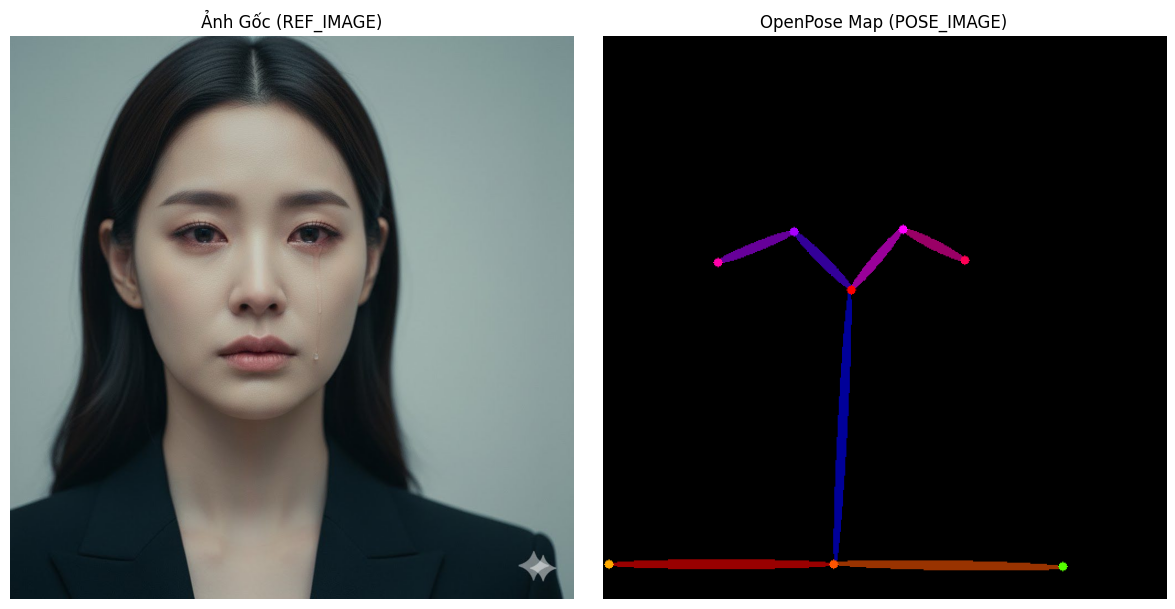


--- HOÀN TẤT CELL 2: UPLOAD, TRÍCH XUẤT/HIỂN THỊ OPENPOSE, GÁN GLOBAL BIẾN ---


In [2]:
# @title [GEMINI] 2. UPDATE ẢNH THAM CHIẾU VÀ TRÍCH XUẤT OPENPOSE

# 1. Tải lên ảnh (Simulate Upload)
# --- Thay thế bằng ảnh thực tế bạn muốn tải lên ---
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io

print("Vui lòng tải lên ảnh của bạn (khuyến nghị ảnh toàn thân):")
uploaded = files.upload()

if uploaded:
    # Lấy tên file đầu tiên được tải lên
    file_name = next(iter(uploaded))
    base_image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
    print(f"-> Đã tải lên ảnh: {file_name}")

    # GÁN ẢNH GỐC VÀO BIẾN TOÀN CỤC (để sử dụng ở các Cell sau)
    globals()['REF_IMAGE'] = base_image # Sử dụng tên biến rõ ràng hơn
    print("-> Đã gán 'REF_IMAGE' vào biến toàn cục.")

else:
    print("!!! LỖI: Không có ảnh nào được tải lên. Dừng lại.")
    # Tạo ảnh đen giả lập để tránh lỗi nếu không tải được ảnh
    base_image = Image.new('RGB', (768, 768), color = 'black')
    globals()['REF_IMAGE'] = base_image
    # Có thể thêm 'return' ở đây nếu muốn dừng hoàn toàn

# 2. Trích xuất OpenPose Map
try:
    # GIẢ ĐỊNH: Biến 'openpose_detector' đã được khởi tạo từ controlnet_aux
    pose_image = openpose_detector(base_image)
    print("-> Đã trích xuất OpenPose Map thành công.")

    # GÁN OPENPOSE IMAGE VÀO BIẾN TOÀN CỤC (để sử dụng ở các Cell sau)
    globals()['POSE_IMAGE'] = pose_image
    print("-> Đã gán 'POSE_IMAGE' vào biến toàn cục.")

except NameError:
    # Xử lý trường hợp 'openpose_detector' chưa được định nghĩa
    print("!!! LỖI: Biến 'openpose_detector' chưa được định nghĩa.")
    pose_image = Image.new('RGB', (768, 768), color = 'red') # Tạo ảnh đỏ báo lỗi
    globals()['POSE_IMAGE'] = pose_image # Gán cả khi lỗi để tránh KeyError sau này


# 3. Hiển thị Ảnh Gốc và OpenPose Map
plt.figure(figsize=(12, 6))

# Hiển thị Ảnh Gốc
plt.subplot(1, 2, 1)
plt.imshow(globals()['REF_IMAGE']) # Dùng biến toàn cục để hiển thị
plt.title("Ảnh Gốc (REF_IMAGE)")
plt.axis('off')

# Hiển thị OpenPose Map
plt.subplot(1, 2, 2)
plt.imshow(globals()['POSE_IMAGE']) # Dùng biến toàn cục để hiển thị
plt.title("OpenPose Map (POSE_IMAGE)")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- HOÀN TẤT CELL 2: UPLOAD, TRÍCH XUẤT/HIỂN THỊ OPENPOSE, GÁN GLOBAL BIẾN ---")

Vui lòng tải lên ảnh (Base Image) để trích xuất Depth Map:


No model was supplied, defaulted to Intel/dpt-large and revision bc15f29 (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.


Saving v33.jpg to v33 (3).jpg
-> Đã tải lên ảnh: v33 (3).jpg
-> Đang trích xuất Depth Map bằng 'depth-estimation' pipeline...


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


-> Đã trích xuất và chuẩn hóa Depth Map thành công.


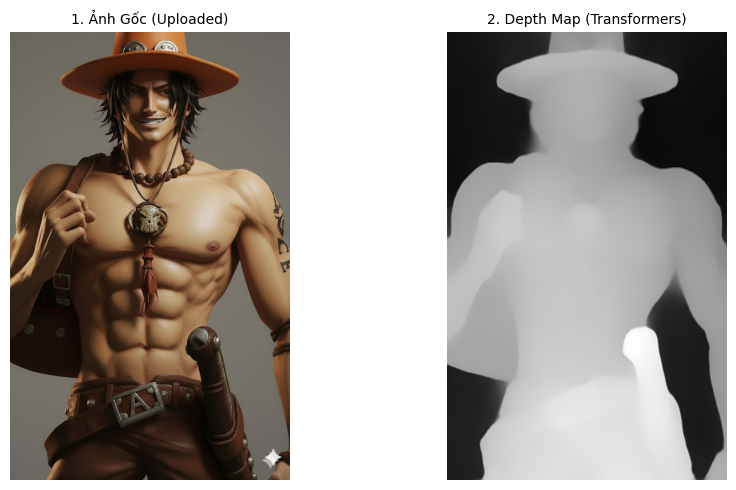


--- HOÀN TẤT CELL TEST: UPLOAD VÀ TRÍCH XUẤT/HIỂN THỊ DEPTH MAP ---


In [ ]:
# @title [GEMINI] 3. UPDATE ẢNH THAM CHIẾU AI VÀ TRÍCH XUẤT DEPTH MAP  (Sử dụng TRANSFORMERS)


import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import io
# Cần cài đặt và import pipeline từ thư viện 'transformers'
from transformers import pipeline
# Cần import files từ google.colab nếu chạy trong Colab
try:
    from google.colab import files
except ImportError:
    print("WARNING: Không tìm thấy google.colab.files. Sẽ cần thay thế bằng Image.open() nếu không chạy trong Colab.")

# --- KHỞI TẠO (GIẢ ĐỊNH) ---
# Thường bạn sẽ cần xác định thiết bị (device) trước, ví dụ:
# import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Dùng CPU cho test nhanh nếu không có CUDA

# --- BƯỚC 1: TẢI LÊN ẢNH ---
print("Vui lòng tải lên ảnh (Base Image) để trích xuất Depth Map:")
uploaded = {}
try:
    # Chỉ chạy trong Google Colab
    uploaded = files.upload()
except:
    # Thay thế bằng đường dẫn ảnh cục bộ nếu không dùng Colab
    # uploaded['local_test_image.jpg'] = 'Tải ảnh của bạn vào đây'
    pass

if uploaded:
    # Lấy tên file đầu tiên được tải lên và mở ảnh
    file_name = next(iter(uploaded))
    # Mở ảnh từ bộ nhớ đệm
    base_image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
    print(f"-> Đã tải lên ảnh: {file_name}")
else:
    print("!!! LỖI: Không có ảnh nào được tải lên hoặc lỗi tải file. Dừng lại.")
    # Tạo ảnh đen giả lập để tránh lỗi
    base_image = Image.new('RGB', (768, 768), color = 'black')
    # Có thể thêm 'return' ở đây nếu muốn dừng hoàn toàn

# --- BƯỚC 2: TRÍCH XUẤT DEPTH MAP BẰNG TRANSFORMERS PIPELINE ---
print("-> Đang trích xuất Depth Map bằng 'depth-estimation' pipeline...")

# Khởi tạo Depth Pipeline của Transformers
# Lần chạy đầu tiên có thể mất thời gian để tải model
try:
    depth_estimator_pipeline = pipeline('depth-estimation', device=device)

    # Trích xuất Depth Map
    depth_result = depth_estimator_pipeline(base_image)['depth']

    # 3. Chuẩn hóa Depth Map để ControlNet có thể sử dụng (0-255 RGB)
    image_np = np.array(depth_result)
    # Chuẩn hóa về 0-1
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    # Chuẩn hóa về 0-255 (uint8)
    image_np = (image_np * 255).astype(np.uint8)

    # Chuyển đổi sang 3 kênh (ControlNet cần RGB)
    # Thêm chiều thứ 3, sau đó nối 3 kênh lại
    image_np = image_np[:, :, None]
    depth_map_image = Image.fromarray(np.concatenate([image_np, image_np, image_np], axis=2))

    # Gán vào biến toàn cục (nếu cần cho các cell sau)
    globals()['BG_DEPTH_MAP'] = depth_map_image
    print("-> Đã trích xuất và chuẩn hóa Depth Map thành công.")

except Exception as e:
    print(f"!!! LỖI XỬ LÝ DEPTH MAP: {e}")
    globals()['BG_DEPTH_MAP'] = Image.new('RGB', (768, 768), color = 'white') # Depth Map trung tính

# --- BƯỚC 3: HIỂN THỊ KIỂM TRA ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(base_image);
axes[0].set_title("1. Ảnh Gốc (Uploaded)", fontsize=10);
axes[0].axis('off')

# Hiển thị Depth Map (Sử dụng 'gray' cmap để dễ nhìn)
axes[1].imshow(globals()['BG_DEPTH_MAP'], cmap='gray');
axes[1].set_title("2. Depth Map (Transformers)", fontsize=10);
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\n--- HOÀN TẤT CELL TEST: UPLOAD VÀ TRÍCH XUẤT/HIỂN THỊ DEPTH MAP ---")

In [ ]:
# ============================================================
# 💎 CẤU HÌNH TỐI ƯU CUỐI CÙNG CHO ẢNH REALISTIC (Portgas D. Ace)
# ============================================================

# MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"

# --- 1. PROMPT ---
FINAL_PROMPT = f"""
Ultra-realistic cinematic portrait of Portgas D. Ace as a real human.
Medium close-up from waist up, keeping the same pose and lighting as the reference.
Natural tan skin with visible pores, micro details, freckles, and sea-weathered tone.
Real human hair — slightly messy, sun-bleached brown, individual strands softly backlit.
Short uneven stubble around chin and jaw, perfectly blended with skin.
Realistic eyes full of depth and emotion, moist and expressive under warm sunlight.
Subtle sheen of sweat and fine dust, mild scars and freckles showing life at sea.
Cinematic HDR lighting, 35mm film depth, soft volumetric rim light, subtle lens flare.
Rendered in 8K photorealistic film quality, warm orange and muted brown tones.
Emotion: proud sorrow, quiet acceptance, brotherly love before death.
"""

NEG_PROMPT_FULL = """
cartoon, anime, digital painting, cgi, wax skin, plastic texture,
over-smooth skin, artificial light, doll face, fake beard, painted hair,
symmetrical face, synthetic texture, illustration, 3D render, oversaturated,
blurry eyes, flat color, unrealistic reflection, toy look, wax statue, fake lighting
"""

# --- 2. THAM SỐ TỐI ƯU CHO SDXL (ĐÃ CHỈNH GIÁ TRỊ) ---
STRENGTH_I2I = 0.20            # Giữ ~58% ảnh gốc, tập trung refine da & tóc nhẹ nhàng
NUM_INFERENCE_STEPS = 250      # Cân bằng chi tiết và thời gian chạy
GUIDANCE_SCALE = 6.8           # Giữ tính chân thực, tránh hiệu ứng CGI quá tay
CONTROLNET_SCALES = [0.6, 0.6] # Giữ cấu trúc pose/depth ổn định nhưng vẫn có tác động
SEED_IMAGE = 9850152               # Cố định seed để có kết quả tái lập


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['uneven stubble around chin and jaw , perfectly blended with skin . realistic eyes full of depth and emotion , moist and expressive under warm sunlight . subtle sheen of sweat and fine dust , mild scars and freckles showing life at sea . cinematic hdr lighting , 3 5 mm film depth , soft volumetric rim light , subtle lens flare . rendered in 8 k photorealistic film quality , warm orange and muted brown tones . emotion : proud sorrow , quiet acceptance , brotherly love before death .']


-> Thiết bị được thiết lập là: cuda (GPU/CUDA).

BẮT ĐẦU TẠO ẢNH CUỐI CÙNG CHO NU_1_Action_Uniform_V2 VỚI DUAL CONTROLNET...


  0%|          | 0/50 [00:00<?, ?it/s]

-> Đã tạo ảnh kết quả thành công.
-> Đã gán 'FINAL_GENERATED_IMAGE' vào biến toàn cục.
-> Đã lưu ảnh tại: Pro_Consistency_Output/Final_Pose_NU_FINAL_IMAGE.png

*** HIỂN THỊ TỔNG HỢP CÁC THÀNH PHẦN (4 Cột) ***


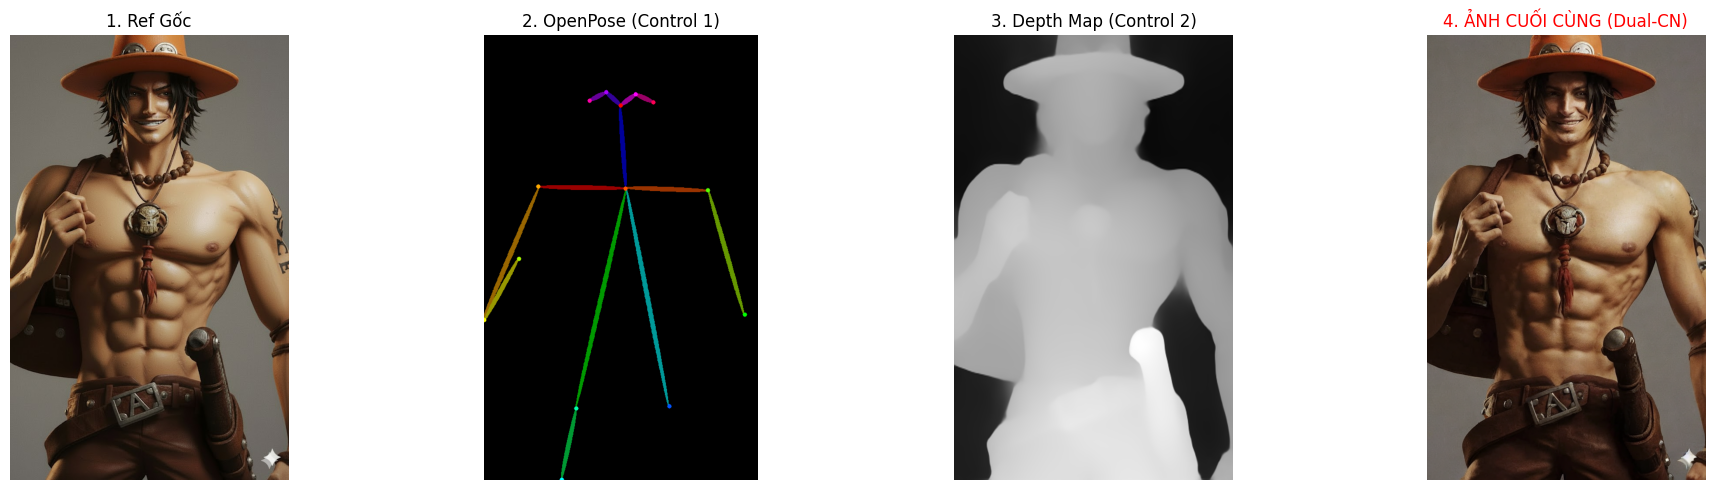


--- HOÀN TẤT CELL 4: XỬ LÝ VÀ HIỂN THỊ CẶP NU DUY NHẤT ---


In [ ]:

# @title [GEMINI] 4. SẢN XUẤT ẢNH BẰNG DUAL CONTROLNET



import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Giả định: Các biến/module trên đã được import và khởi tạo.

# --- 0. KIỂM TRA VÀ CẤU HÌNH THIẾT BỊ (GPU/CUDA) ---
if torch.cuda.is_available():
    device = "cuda"
    print(f"-> Thiết bị được thiết lập là: {device} (GPU/CUDA).")
else:
    device = "cpu"
    print(f"-> Thiết bị được thiết lập là: {device} (Không tìm thấy GPU/CUDA).")
globals()['device'] = device # Gán lại vào global để sử dụng nhất quán

# --- 1. CẤU HÌNH CHO 1 LẦN CHẠY DUY NHẤT (NỮ - NU) ---
FILE_PREFIX = "NU_1_Action_Uniform_V2"
POSE_FILE = f"{FILE_PREFIX}_openpose.png"
GENDER = "NU"

# Lấy các biến toàn cục (Giả định chúng đã được tải lên/tạo ra)
try:
    REF_IMAGE = globals()['REF_IMAGE']
    POSE_IMAGE  = globals()['POSE_IMAGE']
    BG_DEPTH_MAP = globals()['BG_DEPTH_MAP']
except KeyError as e:
    print(f"!!! LỖI: Thiếu biến toàn cục {e}. Không thể tiếp tục.")
    REF_IMAGE = Image.new('RGB', (768, 768), color = 'black')
    POSE_IMAGE = Image.new('RGB', (768, 768), color = 'gray')
    BG_DEPTH_MAP = Image.new('RGB', (768, 768), color = 'white')






if 'i2i_pipe' in globals() and globals()['i2i_pipe'] is not None:
    print(f"\nBẮT ĐẦU TẠO ẢNH CUỐI CÙNG CHO {FILE_PREFIX} VỚI DUAL CONTROLNET...")

    pose_image_resized = POSE_IMAGE.convert("RGB").resize((768, 768))
    # Di chuyển pipe sang device (Quan trọng để chạy trên GPU)
    globals()['i2i_pipe'].to(device)
    if device == "cuda":
         # Thêm enable_xformers_memory_efficient_attention để tối ưu hóa VRAM
         try:
             globals()['i2i_pipe'].enable_xformers_memory_efficient_attention()
         except Exception:
             print("WARNING: Không thể bật xformers. Có thể không cần thiết hoặc chưa cài đặt.")

    generator = torch.Generator(device).manual_seed(SEED_IMAGE) # Dùng seed cố định

    try:
        # GỌI DUAL CONTROLNET
        generated_image = globals()['i2i_pipe'](
            prompt=FINAL_PROMPT,
            image=REF_IMAGE,
            control_image=[pose_image_resized, BG_DEPTH_MAP], # OpenPose & Depth Map
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=NUM_INFERENCE_STEPS,
            guidance_scale=GUIDANCE_SCALE,
            strength=STRENGTH_I2I,
            controlnet_conditioning_scale=CONTROLNET_SCALES,
            generator=generator
        ).images[0]

        print(f"-> Đã tạo ảnh kết quả thành công.")

        globals()['FINAL_GENERATED_IMAGE'] = generated_image
        print("-> Đã gán 'FINAL_GENERATED_IMAGE' vào biến toàn cục.")

        # --- LƯU KẾT QUẢ ---
        CONSISTENCY_DIR = os.environ.get('CONSISTENCY_DIR', './consistency_output')
        os.makedirs(CONSISTENCY_DIR, exist_ok=True)
        output_filename = f"Final_Pose_NU_FINAL_IMAGE.png"
        final_output_path = os.path.join(CONSISTENCY_DIR, output_filename)
        generated_image.save(final_output_path)
        print(f"-> Đã lưu ảnh tại: {final_output_path}")

    except Exception as e:
        print(f"!!! LỖI KHI GỌI I2I PIPE: {e}. Sử dụng ảnh giả lập.")
        globals()['FINAL_GENERATED_IMAGE'] = generated_image

else:
    print("!!! KHÔNG THỂ CHẠY I2I PIPE VÌ CHƯA KHỞI TẠO HOẶC LỖI KHỞI TẠO (Cell 4a).")
    globals()['FINAL_GENERATED_IMAGE'] = generated_image

# --- 4. HIỂN THỊ KẾT QUẢ CUỐI CÙNG (4 CỘT ĐÃ SỬA ĐỔI) ---
print("\n*** HIỂN THỊ TỔNG HỢP CÁC THÀNH PHẦN (4 Cột) ***")

# Thiết lập figure cho 4 cột: Ref Gốc | OpenPose | Depth Map | Final Image
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Cột 1 (Index 0): Ref Gốc
axes[0].imshow(REF_IMAGE);
axes[0].set_title("1. Ref Gốc", fontsize=12);
axes[0].axis('off')

# Cột 2 (Index 1): OpenPose
axes[1].imshow(POSE_IMAGE);
axes[1].set_title("2. OpenPose (Control 1)", fontsize=12);
axes[1].axis('off')

# Cột 3 (Index 2): Depth Map
axes[2].imshow(BG_DEPTH_MAP, cmap='gray');
axes[2].set_title("3. Depth Map (Control 2)", fontsize=12);
axes[2].axis('off')

# Cột 4 (Index 3): ẢNH CUỐI CÙNG
axes[3].imshow(generated_image);
axes[3].set_title("4. ẢNH CUỐI CÙNG (Dual-CN)", fontsize=12, color='red');
axes[3].axis('off')

plt.tight_layout()
plt.show()

print("\n--- HOÀN TẤT CELL 4: XỬ LÝ VÀ HIỂN THỊ CẶP NU DUY NHẤT ---")

In [ ]:
# @title [GEMINI] 5. KHỞI TẠO CONTROLNET CANNY (Tải Mô hình)

import torch
# Thêm import các classes cần thiết
from diffusers import ControlNetModel, StableDiffusionImg2ImgPipeline
from controlnet_aux import CannyDetector
import gc

print("--- BẮT ĐẦU TẢI CONTROLNET CANNY VÀ PIPELINE ---")

# --- 1. LẤY CÁC BIẾN TOÀN CỤC ---
try:
    # Lấy các biến cần thiết đã được khởi tạo ở Cell 1
    device = globals()['device']
    model_id = globals()['model_id']
    print(f"-> Sử dụng thiết bị: {device} và Model ID: {model_id}")
except KeyError as e:
    print(f"!!! LỖI: Thiếu biến toàn cục {e}. Vui lòng chạy Cell 1/Khởi tạo.")
    # Cần dừng lại nếu thiếu biến quan trọng này
    raise

# --- 2. TẢI VÀ LƯU TRỮ CÁC THÀNH PHẦN ---
try:
    # 2a. Tải Canny Detector (ControlNet Aux)
    # Gán vào globals để Cell 6 sử dụng
    globals()['canny_detector'] = CannyDetector()
    print("✅ Đã khởi tạo CannyDetector.")

    # 2b. Tải Canny ControlNet Model
    canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16).to(device)
    globals()['canny_controlnet'] = canny_controlnet # Lưu trữ mô hình ControlNet
    print("✅ Đã tải Canny ControlNet Model.")

    # 2c. Tải StableDiffusionImg2ImgPipeline
    canny_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, controlnet=canny_controlnet, torch_dtype=torch.float16).to(device)

    if device == "cuda":
        try:
            canny_pipe.enable_xformers_memory_efficient_attention()
            print("-> Đã bật xformers để tối ưu VRAM.")
        except Exception:
            pass # Giữ nguyên pass nếu xformers không cài đặt

    globals()['canny_pipe'] = canny_pipe # Lưu trữ Pipeline
    print("✅ Đã tải Canny Pipeline thành công.")

except Exception as e:
    print(f"!!! LỖI TẢI CONTROLNET CANNY: {e}.")
    raise # Dừng quá trình nếu tải thất bại

print("\n--- HOÀN TẤT CELL 5: CONTROLNET CANNY ĐÃ SẴN SÀNG TRONG BỘ NHỚ ---")

--- BẮT ĐẦU TẢI CONTROLNET CANNY VÀ PIPELINE ---
-> Sử dụng thiết bị: cuda và Model ID: runwayml/stable-diffusion-v1-5
✅ Đã khởi tạo CannyDetector.


config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# =========================================================
# === BỘ THAM SỐ TINH CHỈNH TỐI ƯU (HOÀN HẢO) ===
# =========================================================
# Tham số Canny
CANNY_LOW_THRESHOLD = 50
CANNY_HIGH_THRESHOLD = 180 # Tăng ngưỡng cao để lọc bớt chi tiết thừa, tập trung vào đường viền rõ nét
REFINEMENT_SEED = 999

# Tham số Diffusion
REFINEMENT_STRENGTH = 0.25 # Tăng nhẹ để thêm chi tiết kết cấu dễ dàng hơn (0.25 * 80 = 20 bước)
REFINEMENT_SCALE = 0.8
REFINEMENT_STEPS = 80      # Điều chỉnh lại tổng số bước để giữ 20 bước thực tế
REFINEMENT_GUIDANCE = 6.5  # Giữ nguyên 6.5

# Prompt (Tập trung vào Chi tiết Kết cấu và Tính chân thật)
PROMPT_DETAIL = "hyper-detailed photorealistic skin and fabric texture, extreme sharp focus, ultra high resolution, 8k"
PROMPT_STYLE_HINT = "cinematic, deep shadow, wet, high contrast"
FINAL_REFINEMENT_PROMPT = f"{PROMPT_DETAIL}, {PROMPT_STYLE_HINT}"

# Negative Prompt (Chống lại tính nhân tạo)
NEG_PROMPT_REFINE = "blurry, low quality, deformed, unreal, digital painting, illustration, flat lighting"
# =========================================================

-> Đã lấy thành công ảnh và các biến cấu hình.

--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---
-> Đang trích xuất Canny Map...
-> Đang chạy ControlNet Canny để tinh chỉnh...


  0%|          | 0/20 [00:00<?, ?it/s]

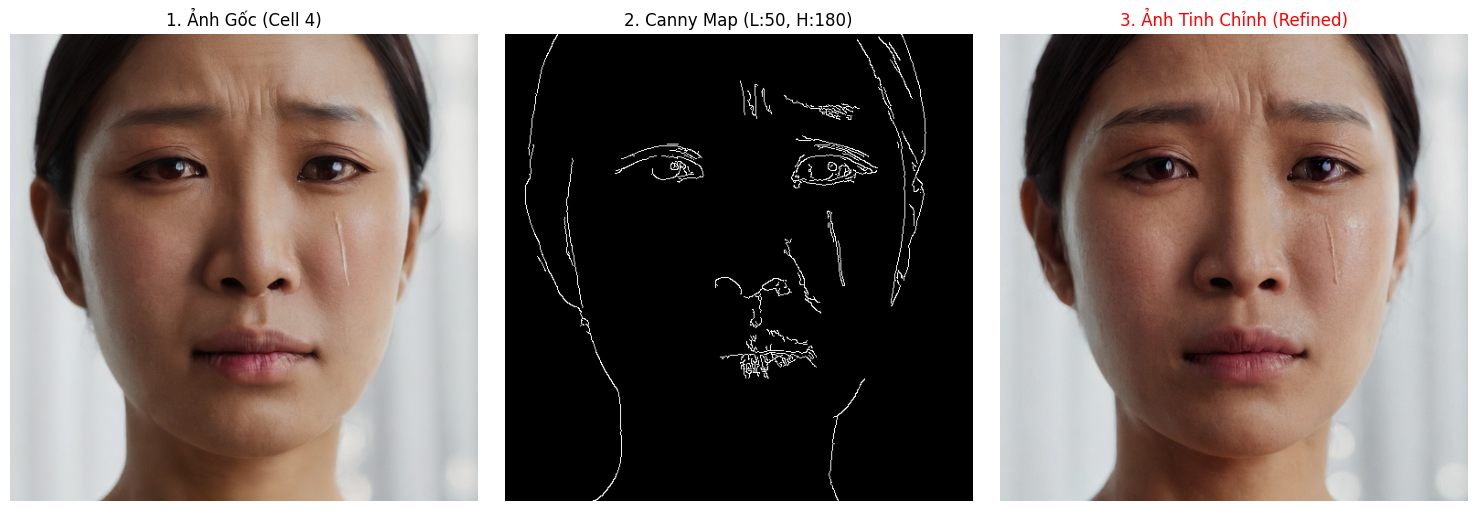


--- BẮT ĐẦU GIẢI PHÓNG BỘ NHỚ CANNY ---

--- HOÀN TẤT CELL 6: TINH CHỈNH VÀ DỌN DẸP CANNY THÀNH CÔNG ---


In [ ]:
# @title [GEMINI] 5. CHẠY TINH CHỈNH CANNY & DỌN DẸP BỘ NHỚ CANNY (Hoàn Chỉnh)

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import gc # Thêm gc cho việc dọn dẹp



# --- 1. KIỂM TRA VÀ TẢI CÁC BIẾN CẦN THIẾT ---
try:
# Lấy ảnh kết quả cuối cùng từ Cell 4
  original_image = globals()['FINAL_GENERATED_IMAGE']

  # Lấy các biến cấu hình từ các cell trước
  device = globals()['device']
  canny_detector = globals()['canny_detector']
  canny_pipe = globals()['canny_pipe'] # SỬA LỖI: Lấy canny_pipe

  # Khởi tạo các biến lỗi fallback
  canny_map = Image.new('RGB', (768, 768), color = 'white')
  refined_image = original_image.copy()

  print("-> Đã lấy thành công ảnh và các biến cấu hình.")

except KeyError as e:
  print(f"!!! LỖI: Thiếu biến toàn cục {e}. Vui lòng chạy Cell Tải Mô hình trước.")
  # Fallback cho việc hiển thị để tránh crash
  original_image = Image.new('RGB', (768, 768), color = 'red')
  canny_map = Image.new('RGB', (768, 768), color = 'white')
  refined_image = original_image.copy()
  print("!!! KHÔNG THỂ CHẠY TINH CHỈNH.")

except ImportError as e:
   print(f"!!! LỖI: Thiếu thư viện hoặc module: {e}")
   canny_map = Image.new('RGB', (768, 768), color = 'white')
   refined_image = original_image.copy()


# --- 2. THỰC THI CHẠY TINH CHỈNH ---
print("\n--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---")

try:

  # --- 2a. TRÍCH XUẤT CANNY MAP ---
  print("-> Đang trích xuất Canny Map...")
  # SỬ DỤNG BIẾN THAM SỐ cho ngưỡng
  canny_map = canny_detector(original_image, low_threshold=CANNY_LOW_THRESHOLD, high_threshold=CANNY_HIGH_THRESHOLD)

  # --- 2b. CHẠY REFINEMENT ---
  print("-> Đang chạy ControlNet Canny để tinh chỉnh...")

  # Chạy Refinement với strength thấp và prompt tập trung vào chi tiết
  refined_image = canny_pipe(
  prompt=FINAL_REFINEMENT_PROMPT,
    image=original_image, control_image=canny_map,
    negative_prompt=NEG_PROMPT_REFINE,
    num_inference_steps=REFINEMENT_STEPS,
    guidance_scale=REFINEMENT_GUIDANCE,
    strength=REFINEMENT_STRENGTH,
    controlnet_conditioning_scale=REFINEMENT_SCALE,
    # SỬ DỤNG BIẾN SEED THAM SỐ
    generator=torch.Generator(device).manual_seed(REFINEMENT_SEED)
  ).images[0]

except Exception as e:
  print(f"!!! LỖI CHẠY CONTROLNET CANNY: {e}. KHÔNG THỂ TINH CHỈNH.")
  refined_image = original_image.copy()

# --- 3. HIỂN THỊ SO SÁNH ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Cột 1: Ảnh Gốc (Cell 4)
axes[0].imshow(original_image); axes[0].set_title("1. Ảnh Gốc (Cell 4)"); axes[0].axis('off')
# Cột 2: Canny Map
axes[1].imshow(canny_map, cmap='gray'); axes[1].set_title(f"2. Canny Map (L:{CANNY_LOW_THRESHOLD}, H:{CANNY_HIGH_THRESHOLD})"); axes[1].axis('off')
# Cột 3: Ảnh Tinh Chỉnh
axes[2].imshow(refined_image); axes[2].set_title("3. Ảnh Tinh Chỉnh (Refined)", color='red'); axes[2].axis('off')

plt.tight_layout()
plt.show()

# =========================================================
# === BƯỚC 4: GIẢI PHÓNG BỘ NHỚ CANNY ===
# =========================================================

print("\n--- BẮT ĐẦU GIẢI PHÓNG BỘ NHỚ CANNY ---")

# Dùng globals() thay vì kiểm tra locals() để dọn dẹp biến toàn cục
# if 'canny_pipe' in globals():
#     pipe_to_delete = globals()['canny_pipe']
#     if hasattr(pipe_to_delete, 'to'):
#         pipe_to_delete.to('cpu')
#     del globals()['canny_pipe']
#     print("✅ Đã giải phóng ControlNet Canny Pipeline khỏi VRAM/RAM.")

# if 'canny_controlnet' in globals():
#     obj = globals()['canny_controlnet']
#     if hasattr(obj, 'to'): obj.to('cpu')
#     del globals()['canny_controlnet']
#     print("✅ Đã giải phóng Canny ControlNet Model khỏi VRAM/RAM.")

# if 'canny_detector' in globals():
#     del globals()['canny_detector']
#     print("✅ Đã xóa Canny Detector khỏi RAM.")

# torch.cuda.empty_cache()
# gc.collect()
# print("✅ Đã dọn dẹp cache VRAM và Python Garbage Collector.")

print("\n--- HOÀN TẤT CELL 6: TINH CHỈNH VÀ DỌN DẸP CANNY THÀNH CÔNG ---")

In [ ]:
# @title [GEMINI] 6. DỌN DẸP BỘ NHỚ VRAM (GPU) VÀ RAM (PYTHON) - TỐI ƯU

import torch
import gc
import sys

# --- CẤU HÌNH BIẾN ---
device = "cuda" if torch.cuda.is_available() else "cpu"

print("--- BẮT ĐẦU GIẢI PHÓNG BỘ NHỚ (UNLOAD) TỐI ƯU ---")

# Danh sách các biến cần xóa (mô hình, ảnh, generator)
VARS_TO_DELETE = [
    # Pipelines chính
    'dual_control_pipe',
    'openpose_detector',
    'depth_estimator_pipeline',
    # Các đối tượng ảnh/data lớn
    #'REF_IMAGE',
    #'POSE_IMAGE',
    #'BG_DEPTH_MAP',
    #'FINAL_GENERATED_IMAGE',
    #'generator'
]

# 1. Xóa tất cả các biến đã biết khỏi bộ nhớ
for var_name in VARS_TO_DELETE:
    if var_name in globals():
        obj_to_delete = globals()[var_name]

        # Đặc biệt xử lý cho Pipelines/Models (Đẩy về CPU rồi xóa)
        if hasattr(obj_to_delete, 'to'):
            try:
                obj_to_delete.to('cpu')
                print(f"✅ Đã đẩy mô hình '{var_name}' về CPU.")
            except Exception as e:
                print(f"⚠️ Không thể đẩy mô hình '{var_name}' về CPU: {e}")

        del globals()[var_name]
        print(f"✅ Đã xóa biến '{var_name}' khỏi RAM.")

# 2. Dọn dẹp bộ nhớ PyTorch (VRAM) và Python (RAM)
if device == "cuda":
    torch.cuda.empty_cache() # Dọn dẹp VRAM
    print("✅ Đã dọn dẹp cache VRAM (torch.cuda.empty_cache).")

# Ép buộc Python thu thập rác để giải phóng RAM
gc.collect()
print("✅ Đã dọn dẹp bộ nhớ Python (gc.collect).")


print("\n--- HOÀN TẤT DỌN DẸP BỘ NHỚ TỐI ƯU. Tài nguyên đã được giải phóng. ---")

In [2]:
# Đảm bảo thư mục /mnt/data tồn tại
!mkdir -p /mnt/data

# Sau đó chạy lệnh tải file SAM
!wget -P /mnt/data https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# --- 0) CÀI ĐẶT/IMPORT ---

print("Segment Anything chưa cài đặt. Đang tiến hành cài đặt...")
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
!pip -q install mediapipe

--2025-10-30 04:04:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.80, 99.84.41.129, 99.84.41.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/mnt/data/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   223MB/s    in 17s     

2025-10-30 04:04:49 (146 MB/s) - ‘/mnt/data/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

Segment Anything chưa cài đặt. Đang tiến hành cài đặt...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 132.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294

-> Thiết bị sẽ sử dụng: cuda. (Dư GPU/VRAM sẽ giúp SAM chạy nhanh hơn).
-> Đang chạy SAM Automatic Mask Generation trên cuda (đã tối ưu tốc độ)...
✔️ Đã tạo SAM Mask (Tối ưu).


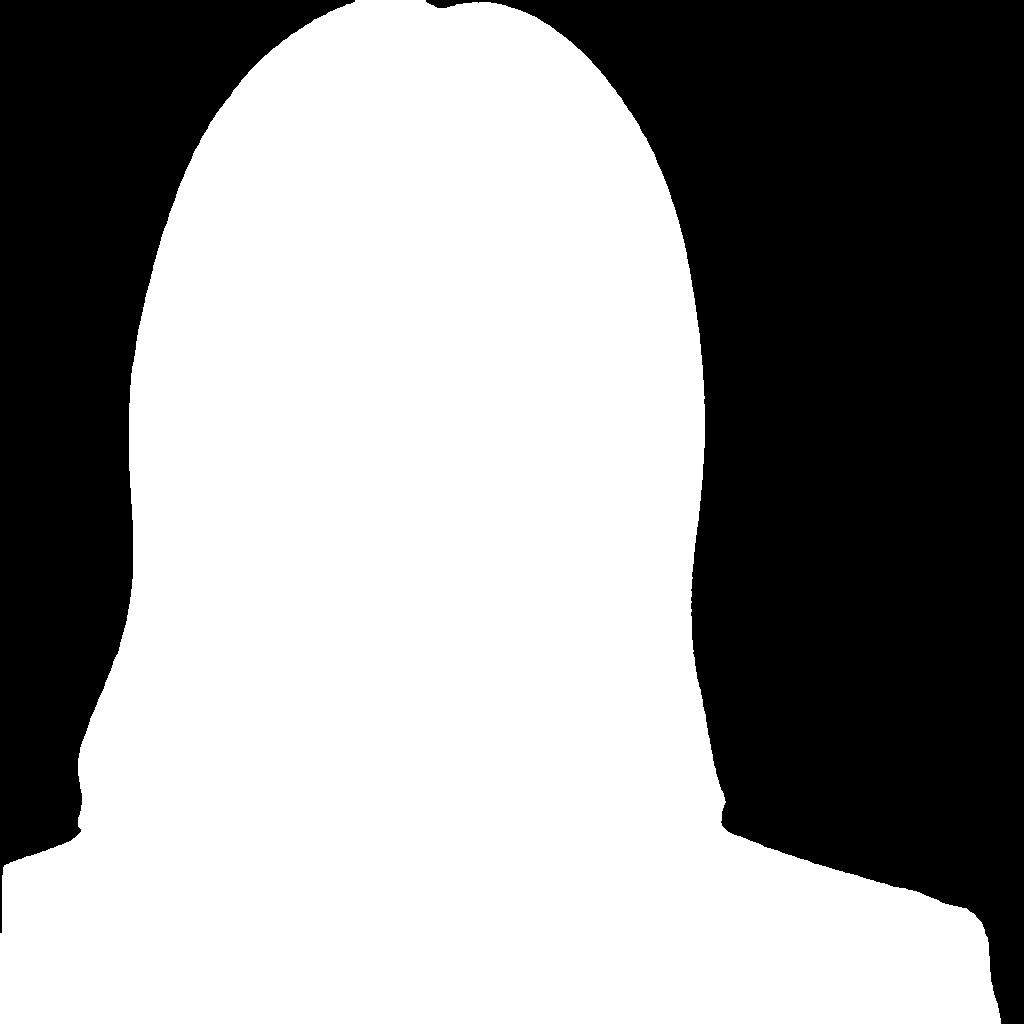

✔️ Đã tạo Face/Skin Mask.


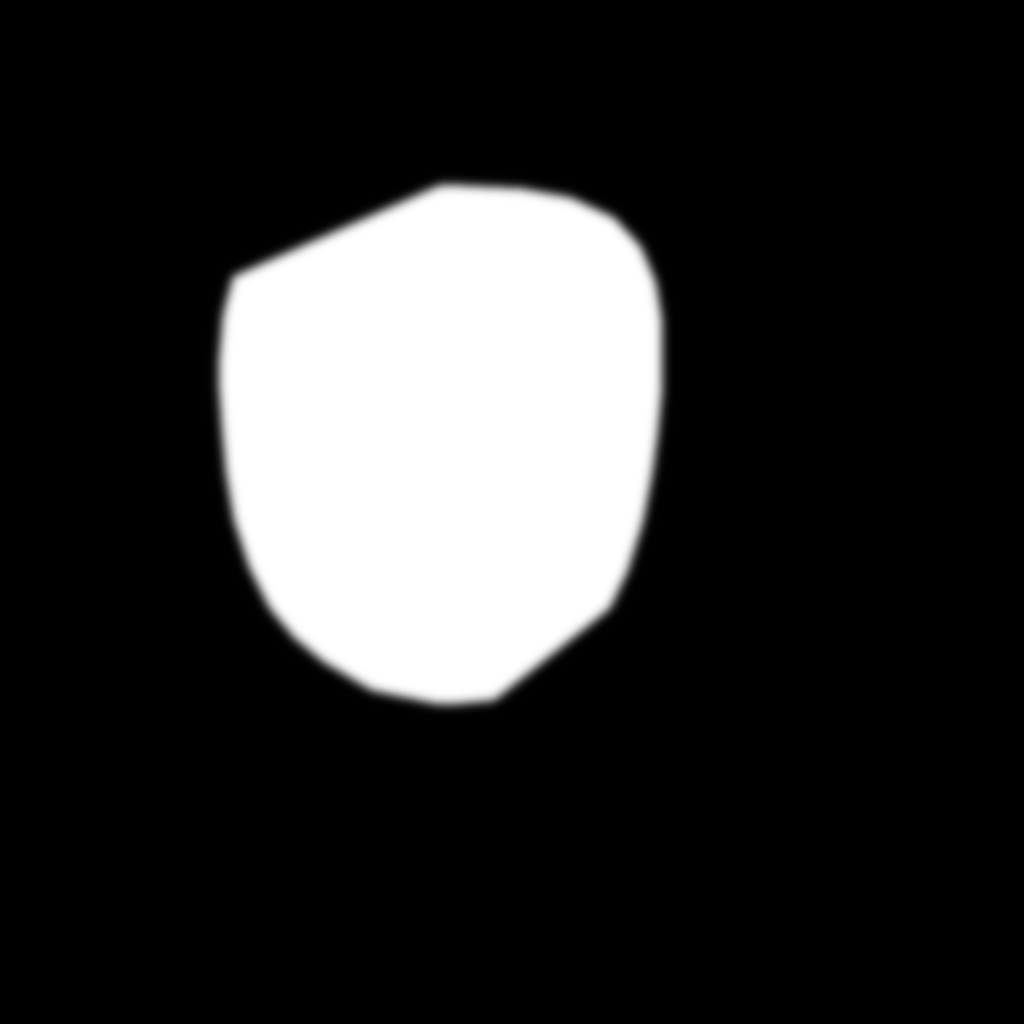


--- Hoàn thành tạo mask ---


In [5]:
# @title [GEMINI] 7. MASK MẶT (Tối ưu hóa tốc độ SAM)

import os
import cv2
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import mediapipe as mp
import torch # Đảm bảo import torch để kiểm tra GPU

# Thiết lập thiết bị mặc định (sẽ là 'cuda' nếu bạn có GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"-> Thiết bị sẽ sử dụng: {device}. (Dư GPU/VRAM sẽ giúp SAM chạy nhanh hơn).")

# --- SETUP TỐI GIẢN ---
IMG_PIL = globals().get('FINAL_GENERATED_IMAGE') or globals().get('REF_IMAGE')
if IMG_PIL is None:
    raise ValueError("Lỗi: Không tìm thấy ảnh đầu vào.")

OUT_DIR = "/content/mask"
os.makedirs(OUT_DIR, exist_ok=True)
IMG_PATH = os.path.join(OUT_DIR, "temp_ref_image_for_mask.png")
IMG_PIL.save(IMG_PATH)
SAM_CHECKPOINT = "/mnt/data/sam_vit_h_4b8939.pth"

# --- LOAD & PROCESS ---
img_bgr = cv2.imread(IMG_PATH)
img_rgb = img_bgr[:, :, ::-1]
h, w = img_rgb.shape[:2]

# 1) SAM Auto Mask (Foreground)
try:
    if not os.path.exists(SAM_CHECKPOINT):
         raise FileNotFoundError("Checkpoint SAM không tìm thấy.")

    sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT)
    sam.to(device=device) # Tải mô hình lên GPU (CUDA)

    # *** SỬA ĐỔI QUAN TRỌNG: TỐI ƯU HÓA SAM ***
    # Giảm số điểm kiểm tra để tăng tốc độ (mặc định là 32)
    # Tùy chọn: points_per_side=16 sẽ nhanh hơn đáng kể
    # stable_mask_threshold=0.9: chỉ giữ lại các mask có độ tin cậy cao
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16,
        pred_iou_thresh=0.9,
        stability_score_thresh=0.9,
        min_mask_region_area=1000,   # Loại bỏ các chi tiết nhiễu nhỏ
    )
    print(f"-> Đang chạy SAM Automatic Mask Generation trên {device} (đã tối ưu tốc độ)...")
    sam_masks = mask_generator.generate(img_rgb)

    # Tìm mask lớn nhất (thường là người/tiền cảnh)
    if not sam_masks:
        raise Exception("Không tìm thấy mask nào.")

    best = max(sam_masks, key=lambda m: m['area'])
    sam_mask = (best['segmentation']).astype(np.uint8) * 255
    sam_mask_path = os.path.join(OUT_DIR, "sam_mask.png")
    Image.fromarray(sam_mask).save(sam_mask_path)
    print("✔️ Đã tạo SAM Mask (Tối ưu).")
    display(Image.open(sam_mask_path).convert("RGBA"))
except Exception as e:
    print(f"❌ SAM thất bại ({e}). Bỏ qua SAM mask.")
    # Fallback: Tạo mask hình chữ nhật đơn giản
    sam_mask = np.zeros((h, w), dtype=np.uint8)
    sam_mask[h//4:h*3//4, w//4:w*3//4] = 255
    sam_mask_path = os.path.join(OUT_DIR, "sam_mask_fallback.png")
    Image.fromarray(sam_mask).save(sam_mask_path)
    print("-> Đã sử dụng SAM Fallback Mask (Hình chữ nhật giữa).")


# 2) Face Parsing (Mediapipe) (Không đổi)
try:
    mp_face = mp.solutions.face_mesh
    with mp_face.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(img_rgb)
        if results.multi_face_landmarks:
            lm = results.multi_face_landmarks[0].landmark
            outline_idx = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 377, 152, 176, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21]
            pts = [(int(lm[i].x * w), int(lm[i].y * h)) for i in outline_idx]

            mask_face = Image.new("L", (w, h), 0)
            ImageDraw.Draw(mask_face).polygon(pts, fill=255)
            mask_face_np = np.array(mask_face)

            kernel = np.ones((25,25), np.uint8)
            mask_face_np = cv2.dilate(mask_face_np, kernel, iterations=1)
            mask_face_np = cv2.GaussianBlur(mask_face_np, (31,31), 0)

            face_mask_path = os.path.join(OUT_DIR, "face_skin_mask.png")
            Image.fromarray(mask_face_np).save(face_mask_path)
            print("✔️ Đã tạo Face/Skin Mask.")
            display(Image.open(face_mask_path).convert("RGBA"))
        else:
            raise Exception("Không tìm thấy khuôn mặt.")

except Exception as e:
    print(f"❌ Mediapipe thất bại ({e}). Bỏ qua face mask.")
    mask_np = np.zeros((h,w), np.uint8)
    face_mask_path = os.path.join(OUT_DIR, "face_skin_mask_fallback_circle.png")
    Image.fromarray(mask_np).save(face_mask_path)
    print("-> Đã sử dụng Face Fallback Mask (Empty).")

print("\n--- Hoàn thành tạo mask ---")

In [7]:
# @title [GEMINI] 7. MASK DA

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- CONFIG & HELPERS ---
OUT_DIR = "/content/mask"
os.makedirs(OUT_DIR, exist_ok=True)
# Lấy ảnh input đã được lưu tạm thời từ Cell 6a (hoặc Cell 2 nếu không chạy Cell tạo ảnh)
IMG_PATH = os.path.join(OUT_DIR, "temp_ref_image_for_mask.png")
SAM_MASK_PATH = os.path.join(OUT_DIR, "sam_mask.png")
FACE_MASK_PATH = os.path.join(OUT_DIR, "face_skin_mask.png")
MODNET_WEIGHTS = "/mnt/data/modnet_portrait_matting.ckpt"

# Helper function: Lưu tệp và hiển thị (Đã sửa lỗi DeprecationWarning)
def save_and_show(img_array, filename, title=""):
    path = os.path.join(OUT_DIR, filename)

    # Sửa lỗi: Loại bỏ tham số mode='L' không cần thiết
    if len(img_array.shape) == 2:
        # Đối với ảnh thang độ xám (1 kênh), Pillow tự động suy luận
        img_to_save = Image.fromarray(img_array)
    else:
        img_to_save = Image.fromarray(img_array)

    img_to_save.save(path)
    print(f"✔️ {title} saved to: {path}")

    try:
        if 'display' in globals():
            display(Image.open(path).convert("RGBA"))
    except Exception:
        plt.imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None);
        plt.title(title); plt.axis('off'); plt.show()
    return path

# -------------------------
# 1) Load Masks và Create Trimap
# -------------------------
try:
    img = cv2.imread(IMG_PATH)
    if img is None: raise FileNotFoundError(f"Input image not found: {IMG_PATH}")

    # --- Load SAM Mask (có fallback) ---
    sam_mask_files = [SAM_MASK_PATH, os.path.join(OUT_DIR, "sam_mask_grabcut_fallback.png")]
    sam_mask = next((cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in sam_mask_files if os.path.exists(f)), None)

    # --- Load Face Mask (có fallback) ---
    face_mask_files = [FACE_MASK_PATH, os.path.join(OUT_DIR, "face_skin_mask_fallback_circle.png")]
    face_mask = next((cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in face_mask_files if os.path.exists(f)), None)

    if sam_mask is None or face_mask is None:
        raise FileNotFoundError("Lỗi: Không tìm thấy cả mask SAM/Grabcut LẪN mask Face/Fallback. Chạy Cell 6a trước.")

except Exception as e:
    raise RuntimeError(f"Lỗi tải mask/ảnh: {e}")

# Normalize masks to binary 0/255
_, sam_thr = cv2.threshold(sam_mask, 127, 255, cv2.THRESH_BINARY)
_, face_thr = cv2.threshold(face_mask, 127, 255, cv2.THRESH_BINARY)

# Tạo Trimap (255=FG, 128=Unknown, 0=BG)
fg = cv2.bitwise_and(sam_thr, face_thr)
kernel = np.ones((15,15), np.uint8)
fg_dilated = cv2.dilate(fg, kernel, iterations=1)

bg = cv2.bitwise_not(sam_thr)
unknown = cv2.bitwise_and(cv2.bitwise_not(fg_dilated), cv2.bitwise_not(bg))

trimap = np.zeros_like(sam_thr)
trimap[bg == 255] = 0
trimap[fg_dilated == 255] = 255
trimap[unknown == 255] = 128

trimap_path = save_and_show(trimap, "trimap.png", "Trimap")

# -------------------------
# 2) MODNet Matting (Inference) HOẶC Fallback
# -------------------------
use_modnet = False
alpha_uint8 = None
img_pil = Image.open(IMG_PATH).convert("RGB") # Cần PIL image cho MODNet

if os.path.exists(MODNET_WEIGHTS):
    print("⏳ Đang cố gắng chạy MODNet inference...")
    try:
        from modnet import MODNet
        import torch
        from torchvision import transforms

        net = MODNet(backbone_pretrained=False)
        checkpoint = torch.load(MODNET_WEIGHTS, map_location='cpu')
        net.load_state_dict(checkpoint)
        net.eval().to('cuda' if torch.cuda.is_available() else 'cpu')

        # Vẫn sử dụng lỗi này để chuyển sang Fallback, vì code inference chi tiết còn thiếu
        raise NotImplementedError("Cần code tiền xử lý/hậu xử lý/gọi net(input) cụ thể cho MODNet.")

    except ImportError:
        print("❌ Lỗi Import MODNet/PyTorch. Quay về Fallback.")
    except Exception as e:
        print(f"❌ Lỗi MODNet inference ({type(e).__name__}): {e}. Quay về Fallback.")

# -------------------------
# 3) Fallback: Soft Alpha (Sử dụng Blur)
# -------------------------
if not use_modnet:
    print("Sử dụng Fallback Soft Alpha từ Trimap.")
    trimap_f = trimap.astype(np.float32) / 255.0
    alpha = cv2.GaussianBlur(trimap_f, (31,31), 0)
    alpha_uint8 = (np.clip(alpha, 0.0, 1.0) * 255).astype(np.uint8)
    alpha_path = save_and_show(alpha_uint8, "alpha.png", "Fallback Alpha Mask")

# -------------------------
# 4) Final Mask Postprocess
# -------------------------
if alpha_uint8 is not None:
    final = cv2.GaussianBlur(alpha_uint8, (21,21), 0)
    final = np.maximum(final, face_thr) # Đảm bảo vùng mặt được ưu tiên
    final_mask_path = save_and_show(final, "final_mask.png", "Final Editing Mask")

print("\n--- HOÀN TẤT CELL 6B: Đã tạo Trimap, Alpha và Final Mask ---")

✔️ Trimap saved to: /content/mask/trimap.png
Sử dụng Fallback Soft Alpha từ Trimap.
✔️ Fallback Alpha Mask saved to: /content/mask/alpha.png
✔️ Final Editing Mask saved to: /content/mask/final_mask.png

--- HOÀN TẤT CELL 6B: Đã tạo Trimap, Alpha và Final Mask ---


== Kiểm tra file và hiển thị (nếu tồn tại) ==
FOUND: /mnt/data/sam_mask.png
FOUND: /mnt/data/face_skin_mask.png

--- sam_mask.png | size: (1024, 1024) | path: /mnt/data/sam_mask.png


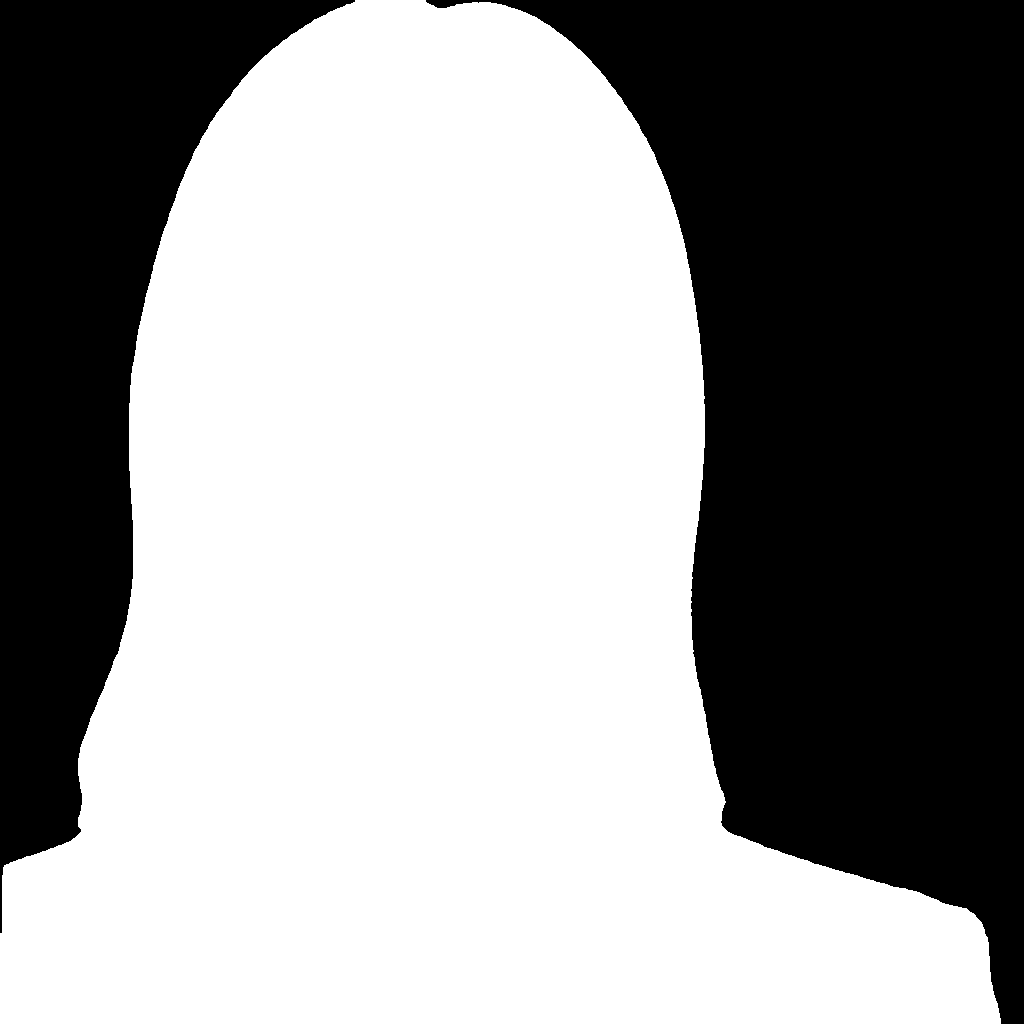


--- face_skin_mask.png | size: (1024, 1024) | path: /mnt/data/face_skin_mask.png


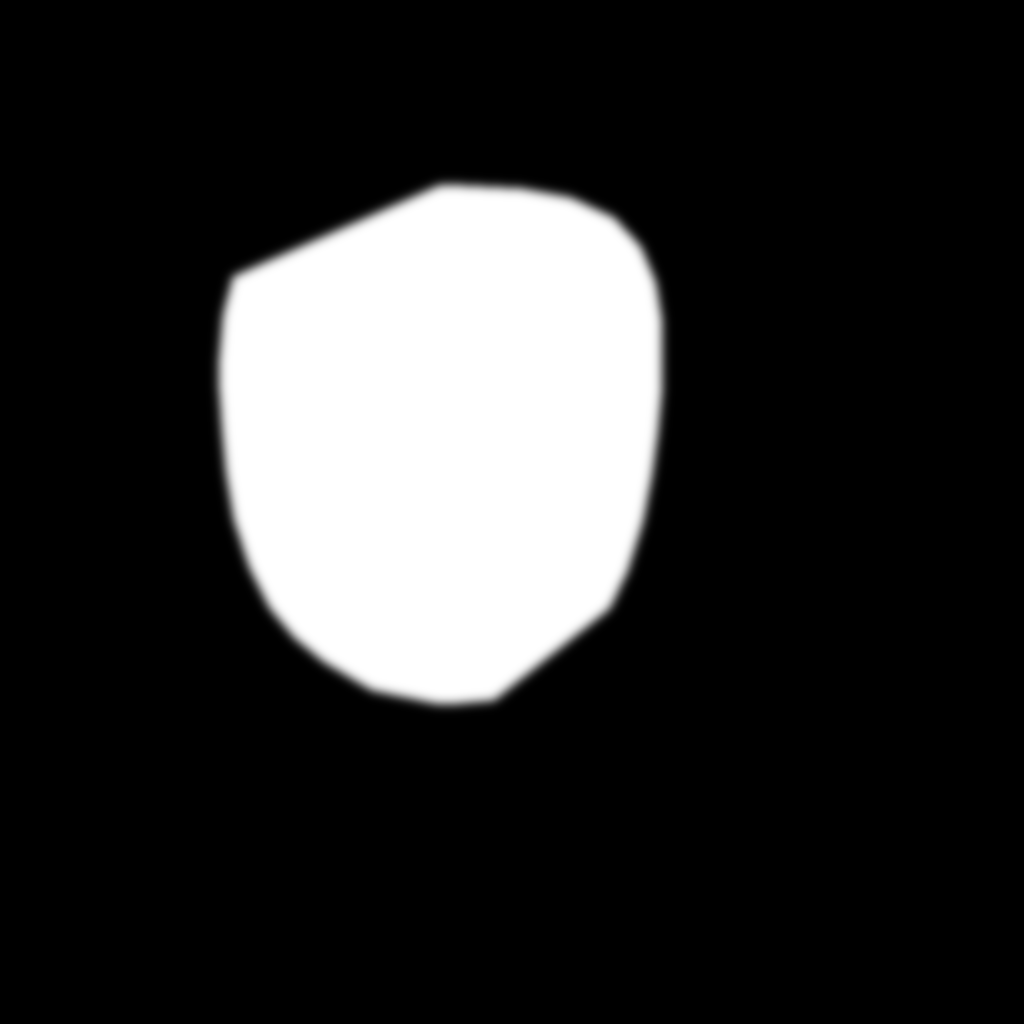


== Colab helper: tạo link download ==
Download link: /mnt/data/sam_mask.png
Download link: /mnt/data/face_skin_mask.png

Bạn có thể tải từng file bằng: from google.colab import files; files.download('path/to/file')



== Hướng dẫn nếu file chưa có: ==
- Nếu 'final_mask.png' hoặc 'alpha.png' không có, kiểm tra Cell 6b có báo lỗi MODNet thiếu không.
- Nếu 'sam_mask.png' không có, kiểm tra Cell 6a log xem SAM checkpoint đã nạp được chưa.
- Để tải file về: trong Colab dùng: from google.colab import files; files.download('/mnt/data/final_mask.png')


In [8]:
# @title [GEMINI] 7. sHOW

# Cell: Hiển thị tất cả các file kết quả và cung cấp link tải (Colab / Jupyter)
import os
from PIL import Image
from IPython.display import display, HTML

OUT_DIR = "/mnt/data"   # nơi các cell 6a/6b lưu file
files_to_check = [
    "sam_mask.png",
    "sam_mask_grabcut.png",
    "face_skin_mask.png",
    "face_skin_mask_fallback.png",
    "trimap.png",
    "alpha.png",
    "final_mask.png",
    "Final_Pose_NU_FINAL_IMAGE.png",
    "Final_Pose_NU_FINAL_IMAGE_REFINED.png",
    "ace_passA_skin.png",
    "ace_passB_hair_beard.png",
    "ace_i2i_refined.png"
]

print("== Kiểm tra file và hiển thị (nếu tồn tại) ==")
found = []
for fname in files_to_check:
    path = os.path.join(OUT_DIR, fname)
    if os.path.exists(path):
        found.append(path)
        print("FOUND:", path)
    else:
        # không in lỗi nhiều, chỉ ghi chú
        pass

if not found:
    print("Không tìm thấy file nào trong danh sách. Hãy kiểm tra lại Cell 6a/6b và đường dẫn OUT_DIR.")
else:
    # Hiển thị tất cả tìm thấy (thu nhỏ để vừa màn hình)
    for p in found:
        try:
            img = Image.open(p)
            print("\n---", os.path.basename(p), "| size:", img.size, "| path:", p)
            display(img)
        except Exception as e:
            print("Không thể mở:", p, "->", e)

# Nếu chạy trên Google Colab: cung cấp link download đơn giản cho mỗi file tìm thấy
try:
    from google.colab import files as gfiles
    print("\n== Colab helper: tạo link download ==");
    for p in found:
        print("Download link:", p)
    print("\nBạn có thể tải từng file bằng: from google.colab import files; files.download('path/to/file')")
except Exception:
    # không phải Colab: in hướng dẫn mở file bằng đường dẫn
    print("\nKhông chạy trên Colab hoặc google.colab không khả dụng. Mở file trực tiếp từ đường dẫn trên hệ thống.")

# Thêm: hiển thị các file cạnh nhau nếu muốn (max 4 per row)
try:
    # create HTML gallery
    html = "<div style='display:flex;flex-wrap:wrap;'>"
    for p in found:
        rel = p
        html += f"<div style='margin:6px;text-align:center'>"
        html += f"<img src='file://{rel}' style='max-width:320px;max-height:240px;display:block;border:1px solid #444'><br>{os.path.basename(p)}</div>"
    html += "</div>"
    display(HTML(html))
except Exception:
    pass

print("\n== Hướng dẫn nếu file chưa có: ==")
print("- Nếu 'final_mask.png' hoặc 'alpha.png' không có, kiểm tra Cell 6b có báo lỗi MODNet thiếu không.")
print("- Nếu 'sam_mask.png' không có, kiểm tra Cell 6a log xem SAM checkpoint đã nạp được chưa.")
print("- Để tải file về: trong Colab dùng: from google.colab import files; files.download('/mnt/data/final_mask.png')")


In [9]:
# @title [GEMINI] 7. EDIT DA VÀ TÓC (Refinement I2I)

# ============================================================
# 💎 TWO-PASS SAFE I2I REFINEMENT (SKIN + HAIR/BEARD)
# ============================================================

from PIL import Image
import cv2
import numpy as np
import torch, os
from IPython.display import display
import matplotlib.pyplot as plt

# --- CONFIG & PATHS ---
OUT_DIR = "/content/outputs/refined"
os.makedirs(OUT_DIR, exist_ok=True)
print("Output directory:", OUT_DIR)

# Paths cho masks (được tạo từ Cell 6b/7)
FINAL_MASK_PATH = "/mnt/data/final_mask.png"       # mặt & da (từ Cell 6b)
SAM_MASK_PATH   = "/mnt/data/sam_mask.png"         # tiền cảnh (từ Cell 7)
FACE_MASK_PATH  = "/mnt/data/face_skin_mask.png"   # mặt/da (từ Cell 7)
HAIR_MASK_PATH  = os.path.join(OUT_DIR, "mask_hair.png") # Sẽ được tạo ở đây

# --- 1) LOAD ẢNH ĐÃ RETOUCH TỪ CELL 6C ---
# Ưu tiên LẤY ẢNH ĐÃ LÀM MỊN DA (FINAL_RETOUCHED_IMAGE)
img_in = globals().get('FINAL_RETOUCHED_IMAGE') or \
         globals().get('FINAL_GENERATED_IMAGE') or \
         globals().get('REF_IMAGE')

if img_in is None:
    # Fallback: Nếu không tìm thấy trong biến global, thử mở file đã lưu từ Cell 6c
    final_retouched_path = os.path.join("/mnt/data", "FINAL_RETOUCHED_IMAGE.png")
    try:
        init_img = Image.open(final_retouched_path).convert("RGB")
        print("-> Đã tải ảnh từ file: FINAL_RETOUCHED_IMAGE.png")
    except Exception:
         raise RuntimeError("Lỗi: Không tìm thấy ảnh đầu vào. Vui lòng chạy Cell 6c trước.")
else:
    init_img = img_in.convert("RGB")
    print("-> Đã lấy ảnh từ biến global (FINAL_RETOUCHED_IMAGE/FINAL_GENERATED_IMAGE).")

W, H = init_img.size

# --- 2) CHUẨN BỊ MASK DA (SKIN MASK) ---
if os.path.exists(FINAL_MASK_PATH):
    mask_skin = Image.open(FINAL_MASK_PATH).convert("L").resize((W,H))
    print("Using final_mask:", FINAL_MASK_PATH)
else:
    # Dùng Fallback đã tạo trong Cell 6b nếu final_mask không tìm thấy
    # (Trường hợp này KHÔNG nên xảy ra nếu Cell 6b chạy thành công)
    raise FileNotFoundError("Lỗi: Không tìm thấy Final Mask. Vui lòng chạy Cell 6b trước.")

mask_skin_path_out = os.path.join(OUT_DIR, "used_final_skin_mask.png")
mask_skin.save(mask_skin_path_out)


# --- 3) CHUẨN BỊ MASK TÓC/RÂU (HAIR/BEARD MASK) ---
if os.path.exists(SAM_MASK_PATH) and os.path.exists(FACE_MASK_PATH):
    try:
        sam = cv2.imread(SAM_MASK_PATH, cv2.IMREAD_GRAYSCALE)
        face = cv2.imread(FACE_MASK_PATH, cv2.IMREAD_GRAYSCALE)

        # Resize về kích thước ảnh hiện tại
        sam = cv2.resize(sam, (W,H), interpolation=cv2.INTER_LINEAR)
        face = cv2.resize(face, (W,H), interpolation=cv2.INTER_LINEAR)

        # Logic tạo mask tóc/râu: Tiền cảnh (SAM) trừ đi Vùng da mặt (FACE)
        # Tóc/râu = SAM_Mask AND NOT(Face_Mask)
        face_inv = cv2.bitwise_not(face)
        hair_np = cv2.bitwise_and(sam, face_inv)

        # Mở rộng/làm mịn để có vùng chuyển tiếp tốt hơn
        k_open = max(5, int(min(W,H)/300))
        hair_np = cv2.morphologyEx(hair_np, cv2.MORPH_OPEN, np.ones((k_open,k_open), np.uint8))
        hair_np = cv2.GaussianBlur(hair_np, (11,11), 0)

        mask_hair = Image.fromarray(hair_np).convert("L")
        mask_hair.save(HAIR_MASK_PATH)
        print("Auto-created hair mask saved:", HAIR_MASK_PATH)

    except Exception as e:
        print(f"Lỗi tạo hair mask tự động: {e}. Dùng fallback.")
        mask_hair = Image.fromarray(np.zeros((H,W), np.uint8)).convert("L")
else:
    # Fallback đơn giản nếu không có mask SAM hoặc FACE
    mask_hair = Image.fromarray(np.zeros((H,W), np.uint8)).convert("L")
    print("⚠️ Thiếu SAM/FACE mask. Dùng hair mask trống (refinement sẽ không hoạt động).")


mask_hair_path_out = os.path.join(OUT_DIR, "used_mask_hair.png")
mask_hair.save(mask_hair_path_out)

# --- 4) CHUẨN BỊ PIPELINE VÀ SEED ---
i2i = globals().get('i2i_pipe') or globals().get('pipe') or globals().get('pipe_img2img')
if i2i is None:
    raise RuntimeError("❌ Không tìm thấy pipeline i2i (i2i_pipe / pipe). Hãy chắc rằng bạn đã khởi tạo SDXL trước.")

device = "cuda" if torch.cuda.is_available() else "cpu"
i2i.to(device)
try:
    i2i.enable_xformers_memory_efficient_attention()
except Exception:
    pass
i2i.enable_attention_slicing()

# Seeds
gen_seed = globals().get('SEED_IMAGE') if 'SEED_IMAGE' in globals() else 707
generator = torch.Generator(device).manual_seed(int(gen_seed))

# --- Lấy Prompts ---
PASS_A_PROMPT = globals().get('FINAL_PROMPT') or "a professional, realistic photograph of a person"
PASS_A_NEG = globals().get('NEG_PROMPT_FULL') or ""

# ============================================================
# PASS A: SKIN MICROTEXTURE REFINEMENT
# ============================================================
STRENGTH_A = 0.18
STEPS_A = 120
CFG_A = 6.8

print("\nRunning Pass A (skin microtexture refinement)...")
out_a = i2i(
    prompt=PASS_A_PROMPT,
    negative_prompt=PASS_A_NEG,
    image=init_img,
    mask_image=mask_skin,
    strength=STRENGTH_A,
    guidance_scale=CFG_A,
    num_inference_steps=STEPS_A,
    generator=generator
).images[0]

out_a_path = os.path.join(OUT_DIR, "ace_passA_skin_refined.png")
out_a.save(out_a_path)
print("✅ Saved Pass A ->", out_a_path)

# ============================================================
# PASS B: HAIR & BEARD REFINEMENT
# ============================================================
PASS_B_PROMPT = "Refine hair and facial stubble: natural strands, highly detailed, photorealistic texture, keep face identical."
STRENGTH_B = 0.12
STEPS_B = 80
CFG_B = 6.0
generator = torch.Generator(device).manual_seed(int(gen_seed)+1)

print("\nRunning Pass B (hair & beard refinement)...")
out_b = i2i(
    prompt=PASS_B_PROMPT,
    negative_prompt=PASS_A_NEG,
    image=out_a,
    mask_image=mask_hair,
    strength=STRENGTH_B,
    guidance_scale=CFG_B,
    num_inference_steps=STEPS_B,
    generator=generator
).images[0]

out_b_path = os.path.join(OUT_DIR, "ace_passB_hair_beard_final.png")
out_b.save(out_b_path)
print("✅ Saved Pass B ->", out_b_path)

# --- Show final result ---
print("\n--- HOÀN TẤT CELL 7: Tinh chỉnh I2I 2 bước thành công ---")
globals()['FINAL_IMAGE_REFINED_I2I'] = out_b

# Hiển thị kết quả cuối cùng
display(out_b)

Output directory: /content/outputs/refined
-> Đã lấy ảnh từ biến global (FINAL_RETOUCHED_IMAGE/FINAL_GENERATED_IMAGE).


FileNotFoundError: Lỗi: Không tìm thấy Final Mask. Vui lòng chạy Cell 6b trước.

In [13]:
# @title [GEMINI] 5b. KHỞI TẠO CONTROLNET CANNY (Tải Mô hình)

# ============================================================
# 💎 TẢI CONTROLNET CANNY VÀ PIPELINE I2I TÍCH HỢP
# ============================================================

import torch
from diffusers import ControlNetModel, StableDiffusionImg2ImgPipeline
from controlnet_aux import CannyDetector
import gc

# --- 1. LẤY CÁC BIẾN TOÀN CỤC ---
try:
    device = globals()['device']
    model_id = globals()['model_id']
    print(f"-> Sử dụng thiết bị: {device} và Model ID: {model_id}")
except KeyError as e:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_id = "runwayml/stable-diffusion-v1-5"
    print(f"!!! LỖI: Thiếu biến toàn cục {e}. Dùng giá trị mặc định.")

# --- 2. TẢI VÀ LƯU TRỮ CONTROLNET CANNY ---
try:
    print("\n--- BẮT ĐẦU TẢI CONTROLNET CANNY VÀ PIPELINE ---")

    # 2a. Tải Canny Detector
    canny_detector = CannyDetector()
    globals()['canny_detector'] = canny_detector # Lưu trữ lại
    print("✅ Đã khởi tạo CannyDetector.")

    # 2b. Tải Canny ControlNet Model (Giả định SD 1.5)
    canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16).to(device)
    globals()['canny_controlnet'] = canny_controlnet # Lưu trữ ControlNet Model

    # 2c. Tải StableDiffusionImg2ImgPipeline VÀ TÍCH HỢP ControlNet
    canny_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, controlnet=canny_controlnet, torch_dtype=torch.float16).to(device)

    if device == "cuda":
        try:
            canny_pipe.enable_xformers_memory_efficient_attention()
            print("-> Đã bật xformers để tối ưu VRAM.")
        except Exception:
            pass

    globals()['canny_pipe'] = canny_pipe # LƯU TRỮ PIPELINE ĐỂ CELL 7 SỬ DỤNG
    print("✅ Đã tải Canny Pipeline thành công.")

except Exception as e:
    print(f"!!! LỖI TẢI CONTROLNET CANNY: {e}. ControlNet sẽ bị vô hiệu hóa.")
    # Dùng Fallback Pipeline nếu ControlNet thất bại
    globals()['canny_pipe'] = globals().get('i2i_pipe') or globals().get('pipe') or None


print("\n--- HOÀN TẤT CELL 5b: CONTROLNET CANNY ĐÃ SẴN SÀNG TRONG BỘ NHỚ ---")

-> Sử dụng thiết bị: cuda và Model ID: runwayml/stable-diffusion-v1-5

--- BẮT ĐẦU TẢI CONTROLNET CANNY VÀ PIPELINE ---
✅ Đã khởi tạo CannyDetector.


config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Keyword arguments {'controlnet': ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
   

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

-> Đã bật xformers để tối ưu VRAM.
✅ Đã tải Canny Pipeline thành công.

--- HOÀN TẤT CELL 5b: CONTROLNET CANNY ĐÃ SẴN SÀNG TRONG BỘ NHỚ ---


In [16]:
# @title [GEMINI] 6. TẠO CANNY EDGE MAP (Chuẩn bị Ảnh Điều Kiện)

# ============================================================
# 💎 SỬ DỤNG CANNY DETECTOR ĐỂ TẠO ẢNH ĐIỀU KIỆN
# ============================================================

from PIL import Image
import os
from IPython.display import display
import numpy as np

# --- 1. LẤY CÁC BIẾN TOÀN CỤC ---
try:
    canny_detector = globals()['canny_detector']
    ref_image = globals()['REF_IMAGE'].convert("RGB")
    print("✅ Đã lấy Canny Detector và REF_IMAGE.")
except KeyError:
    raise RuntimeError("❌ LỖI: Cần chạy Cell 2 (Tải ảnh) và Cell 5b (Tải ControlNet) trước.")

# --- 2. CẤU HÌNH THAM SỐ CANNY ---
# Các ngưỡng Low/High Threshold quyết định độ chi tiết của đường nét
# Thấp: nhiều chi tiết hơn (noise) / Cao: ít chi tiết hơn (chỉ đường nét chính)
CANNY_LOW_THRESHOLD = 100
CANNY_HIGH_THRESHOLD = 200

print(f"\n--- Bắt đầu trích xuất Canny Edge Map (Low={CANNY_LOW_THRESHOLD}, High={CANNY_HIGH_THRESHOLD}) ---")

# --- 3. THỰC HIỆN TRÍCH XUẤT ---
try:
    # CannyDetector trả về ảnh PIL (RGB)
    canny_image = canny_detector(
        ref_image,
        low_threshold=CANNY_LOW_THRESHOLD,
        high_threshold=CANNY_HIGH_THRESHOLD
    )

    # --- 4. LƯU KẾT QUẢ ---
    CANNY_MAP_PATH = "/content/mask/canny_map.png"
    os.makedirs(os.path.dirname(CANNY_MAP_PATH), exist_ok=True)
    canny_image.save(CANNY_MAP_PATH)
    globals()['CANNY_IMAGE_GLOBAL'] = canny_image # Lưu trữ để hiển thị/debug

    print(f"✅ Đã tạo và lưu Canny Edge Map thành công tại: {CANNY_MAP_PATH}")

    # --- HIỂN THỊ KẾT QUẢ ---
    print("\n")
    # display(canny_image)

except Exception as e:
    print(f"!!! LỖI TẠO CANNY MAP: {e}")
    raise

✅ Đã lấy Canny Detector và REF_IMAGE.

--- Bắt đầu trích xuất Canny Edge Map (Low=100, High=200) ---
✅ Đã tạo và lưu Canny Edge Map thành công tại: /content/mask/canny_map.png




In [46]:
# @title [GEMINI] 7. CẤU HÌNH THAM SỐ TINH CHỈNH (Cinematic Emotional Master - MAX Subtlety)

# --- THAM SỐ CẤU HÌNH PROMPT ---

# PASS A (MẶT/FACE): Đạt chất lượng Master Grade, giữ cảm xúc, tập trung vào độ nét và ánh sáng.
PASS_A_PROMPT = "masterpiece, 8K, cinematic emotional portrait, best quality, ultra-sharp focus, professional color grading, subtle face details, analog film texture, hyper-detailed eyes."
PASS_A_NEG = "blurry, low quality, cartoon, smooth skin, plastic look, unrealistic skin texture, over-denoised, digital noise"

# PASS B (CƠ THỂ/BODY): Áp dụng Master Grade Photorealism tinh tế, tập trung vào lighting và độ sâu.
PASS_B_PROMPT = "A cinematic master shot, 8K, professional photograph, analog film grain, volumetric lighting, hyperdetailed muscle tone, clean skin, dramatic shadows, photorealistic master grade."
PASS_B_NEG = "blurry, low quality, flat lighting, rough skin texture, low fidelity, CGI look, excessive grain"

# PASS C (TÓC/FINAL): Tinh chỉnh tóc, độ nét và Final Grade tổng thể.
PASS_C_PROMPT = "Refine hair: 8K, cinematic master grade, natural hair strands, high-frequency detail, crisp final output, perfect color saturation."

# --- THAM SỐ CẤU HÌNH STRENGTH & STEPS ---
# PASS A: FACE REFINEMENT (STRENGTH CỰC KỲ THẤP CHO TÍNH TOÀN VẸN MẶT)
STRENGTH_A = 0.08 # Mức Denoise an toàn nhất (8%)
STEPS_A = 150
CFG_A = 5.5       # CFG SIÊU AN TOÀN

# PASS B: BODY REFINEMENT (STRENGTH CÂN BẰNG TỐT NHẤT CHO MASTER GRADE)
STRENGTH_B = 0.18 # Mức Master Grade cho Body (vẫn giữ cấu trúc cơ bắp cũ)
STEPS_B = 150
CFG_B = 7.0

# PASS C: HAIR & FINAL TOUCH (STRENGTH bảo thủ cho Final Grade)
STRENGTH_C = 0.07 # Final Pass chỉ nên là một lớp phủ mỏng
STEPS_C = 100
CFG_C = 6.5

SEED_IMAGE = 896245802

# --- LƯU TRỮ VÀO GLOBAL SCOPE ---
globals()['PASS_A_PROMPT'] = PASS_A_PROMPT
globals()['PASS_A_NEG'] = PASS_A_NEG
globals()['PASS_B_PROMPT'] = PASS_B_PROMPT
globals()['PASS_B_NEG'] = PASS_B_NEG
globals()['PASS_C_PROMPT'] = PASS_C_PROMPT
globals()['STRENGTH_A'] = STRENGTH_A
globals()['STEPS_A'] = STEPS_A
globals()['CFG_A'] = CFG_A
globals()['STRENGTH_B'] = STRENGTH_B
globals()['STEPS_B'] = STEPS_B
globals()['CFG_B'] = CFG_B
globals()['STRENGTH_C'] = STRENGTH_C
globals()['STEPS_C'] = STEPS_C
globals()['CFG_C'] = CFG_C
globals()['SEED_IMAGE'] = SEED_IMAGE

print(f"✔️ Đã CẤU HÌNH LẠI HOÀN TOÀN thành Cinematic Emotional Master: STRENGTH_A={STRENGTH_A} (8%), STRENGTH_B={STRENGTH_B} (18%).")
print("Chiến lược mới: Ưu tiên tối đa tính toàn vẹn ảnh gốc và Ánh sáng/Color Grade tinh tế.")

✔️ Đã CẤU HÌNH LẠI HOÀN TOÀN thành Cinematic Emotional Master: STRENGTH_A=0.08 (8%), STRENGTH_B=0.18 (18%).
Chiến lược mới: Ưu tiên tối đa tính toàn vẹn ảnh gốc và Ánh sáng/Color Grade tinh tế.


In [ ]:
# @title [GEMINI] 7. EDIT DA VÀ TÓC (Hyper-Safe 3-Pass Refinement: Face > Body > Hair)

# ============================================================
# 💎 THREE-PASS HYPER-SAFE I2I REFINEMENT (FACE > BODY > HAIR)
# ============================================================

from PIL import Image
import cv2
import numpy as np
import os
import torch
from IPython.display import display
import matplotlib.pyplot as plt

# --- CONFIG & PATHS ---
# Thay đổi thư mục đầu ra để chứa các pass mới
OUT_DIR = "/content/outputs/refined_3pass"
os.makedirs(OUT_DIR, exist_ok=True)
print("Output directory:", OUT_DIR)

# Paths cho masks (sử dụng lại các mask đã tạo ở Cell 6)
FINAL_MASK_PATH = "/content/mask/final_mask.png"
SAM_MASK_PATH  = "/content/mask/sam_mask.png"
FACE_MASK_PATH = "/content/mask/face_skin_mask.png"
CANNY_MAP_PATH = "/mnt/data/canny_map.png"

# Paths cho mask mới
HAIR_MASK_PATH = os.path.join(OUT_DIR, "mask_hair.png")
BODY_MASK_PATH  = os.path.join(OUT_DIR, "mask_body_only.png") # MASK MỚI: Chỉ cơ thể

# --- 1) LOAD ẢNH VÀ KÍCH THƯỚC ---
init_img = globals().get('REF_IMAGE').convert("RGB")
if init_img is None:
    # Logic tải ảnh gốc (dùng lại logic cũ)
    REF_IMAGE_PATH_FALLBACK = os.path.join("/mnt/data", "temp_ref_image_for_mask.png")
    if os.path.exists(REF_IMAGE_PATH_FALLBACK):
        try:
            init_img = Image.open(REF_IMAGE_PATH_FALLBACK).convert("RGB")
            print(f"-> Đã tải lại REF_IMAGE từ file: {REF_IMAGE_PATH_FALLBACK}")
        except:
            raise RuntimeError("Lỗi tải REF_IMAGE. Vui lòng chạy Cell 2 để upload ảnh.")
    else:
        raise RuntimeError("Lỗi: Không tìm thấy REF_IMAGE. Vui lòng chạy Cell 2 để upload ảnh.")

W, H = init_img.size


# --- 2) CHUẨN BỊ MASKs (Tạo Mask Body mới) ---

# Kiểm tra sự tồn tại của các mask cần thiết
if not (os.path.exists(FINAL_MASK_PATH) and os.path.exists(SAM_MASK_PATH) and os.path.exists(FACE_MASK_PATH)):
    raise FileNotFoundError("Lỗi: Không tìm thấy đủ các Mask (Final/SAM/Face). Vui lòng chạy Cell 6b trước.")

# Tải và resize các mask cơ bản
mask_full_skin = Image.open(FINAL_MASK_PATH).convert("L").resize((W,H))
mask_face_raw = cv2.imread(FACE_MASK_PATH, cv2.IMREAD_GRAYSCALE)
mask_sam_raw = cv2.imread(SAM_MASK_PATH, cv2.IMREAD_GRAYSCALE)
mask_face = cv2.resize(mask_face_raw, (W,H), interpolation=cv2.INTER_LINEAR)
mask_sam = cv2.resize(mask_sam_raw, (W,H), interpolation=cv2.INTER_LINEAR)

# a) MASK CHO PASS A: FACE ONLY (Sử dụng FACE_MASK đã được làm mịn)
mask_face_pass_a = Image.fromarray(mask_face).convert("L")
print("✅ Mask Pass A (Face) đã sẵn sàng.")

# b) MASK CHO PASS B: BODY ONLY (BODY = FULL_SKIN - FACE)
skin_np = np.array(mask_full_skin.convert("L"))
# Tạo BODY_MASK bằng cách loại bỏ vùng mặt khỏi Skin Mask
body_np = cv2.subtract(skin_np, mask_face)
body_np[body_np < 20] = 0 # Lọc nhiễu
body_np = cv2.GaussianBlur(body_np, (21,21), 0) # Làm mịn viền mask
mask_body = Image.fromarray(body_np).convert("L")
mask_body.save(BODY_MASK_PATH)
print("✅ Mask Pass B (Body Only) đã tự động tạo và lưu.")


# c) MASK CHO PASS C: HAIR/BEARD (Dùng lại logic cũ)
face_inv = cv2.bitwise_not(mask_face)
hair_np = cv2.bitwise_and(mask_sam, face_inv)
k_open = max(5, int(min(W,H)/300))
hair_np = cv2.morphologyEx(hair_np, cv2.MORPH_OPEN, np.ones((k_open,k_open), np.uint8))
hair_np = cv2.GaussianBlur(hair_np, (11,11), 0)
mask_hair = Image.fromarray(hair_np).convert("L")
mask_hair.save(HAIR_MASK_PATH)
print("✅ Mask Pass C (Hair) đã sẵn sàng.")


# --- 3) CHUẨN BỊ PIPELINE, CANNY VÀ THAM SỐ ---
i2i_pipe = globals().get('canny_pipe')
CANNY_ACTIVE = (i2i_pipe is not None) and (globals().get('canny_controlnet') is not None)
device = "cuda" if torch.cuda.is_available() else "cpu"
i2i_pipe.to(device)

if not CANNY_ACTIVE:
    # Nếu ControlNet không hoạt động, tạm thời dừng lại để người dùng kiểm tra
    raise RuntimeError("❌ Lỗi: ControlNet Pipeline không hoạt động. Vui lòng chạy Cell 5b và 6.")

canny_image = Image.open(CANNY_MAP_PATH).convert("RGB").resize((W, H)) if os.path.exists(CANNY_MAP_PATH) else None
if canny_image is None:
     raise RuntimeError("❌ Lỗi: Không tìm thấy Canny Map. Vui lòng chạy Cell 6.")

gen_seed = globals().get('SEED_IMAGE', 707)
generator = torch.Generator(device).manual_seed(int(gen_seed))

# Lấy Prompts & Tham số TỪ GLOBAL (Đã cấu hình 3 Pass)
PASS_A_PROMPT = globals().get('PASS_A_PROMPT', "Default Pass A")
PASS_A_NEG = globals().get('PASS_A_NEG', "Default Neg")
PASS_B_PROMPT = globals().get('PASS_B_PROMPT', "Default Pass B")
PASS_B_NEG = globals().get('PASS_B_NEG', "Default Neg")
PASS_C_PROMPT = globals().get('PASS_C_PROMPT', "Default Pass C")
STRENGTH_A = globals().get('STRENGTH_A', 0.12)
CFG_A = globals().get('CFG_A', 6.0)
STRENGTH_B = globals().get('STRENGTH_B', 0.20)
CFG_B = globals().get('CFG_B', 7.5)
STRENGTH_C = globals().get('STRENGTH_C', 0.15)
CFG_C = globals().get('CFG_C', 6.8)
STEPS_A = globals().get('STEPS_A', 600)
STEPS_B = globals().get('STEPS_B', 600)
STEPS_C = globals().get('STEPS_C', 80)
CN_SCALE_A = 0.20
CN_SCALE_B = 0.30
CN_SCALE_C = 0.25


# ============================================================
# PASS A: FACE REFINEMENT (Siêu An Toàn cho Nước Mắt)
# ============================================================
print("\nRunning Pass A (FACE safe refinement)...")
print(f"-> PROMPT: {PASS_A_PROMPT}")
print(f"-> STRENGTH_A={STRENGTH_A}, CFG_A={CFG_A}, STEPS_A={STEPS_A}")

cn_args_a = {
    'controlnet_conditioning_image': canny_image,
    'controlnet_conditioning_scale': CN_SCALE_A
}

out_a = i2i_pipe(
    prompt=PASS_A_PROMPT,
    negative_prompt=PASS_A_NEG,
    image=init_img,
    mask_image=mask_face_pass_a,
    strength=STRENGTH_A,
    guidance_scale=CFG_A,
    num_inference_steps=STEPS_A,
    generator=generator,
    **cn_args_a
).images[0]

out_a_path = os.path.join(OUT_DIR, "ace_passA_face_safe_refined.png")
out_a.save(out_a_path)
print(f"✅ Saved Pass A (Face Safe) ->", out_a_path)


# ============================================================
# PASS B: BODY REFINEMENT (Cinematic Texture cho Cơ Thể)
# ============================================================
print("\nRunning Pass B (BODY cinematic refinement)...")
print(f"-> PROMPT: {PASS_B_PROMPT}")
print(f"-> STRENGTH_B={STRENGTH_B}, CFG_B={CFG_B}, STEPS_B={STEPS_B}")
generator = torch.Generator(device).manual_seed(int(gen_seed)+1)

cn_args_b = {
    'controlnet_conditioning_image': canny_image,
    'controlnet_conditioning_scale': CN_SCALE_B
}

out_b = i2i_pipe(
    prompt=PASS_B_PROMPT,
    negative_prompt=PASS_B_NEG,
    image=out_a, # Input là kết quả của Pass A
    mask_image=mask_body, # Mask Body Only
    strength=STRENGTH_B,
    guidance_scale=CFG_B,
    num_inference_steps=STEPS_B,
    generator=generator,
    **cn_args_b
).images[0]

out_b_path = os.path.join(OUT_DIR, "ace_passB_body_cinematic_refined.png")
out_b.save(out_b_path)
print(f"✅ Saved Pass B (Body Cinematic) ->", out_b_path)


# ============================================================
# PASS C: HAIR & FINAL TOUCH
# ============================================================
print("\nRunning Pass C (HAIR & FINAL touch)...")
print(f"-> PROMPT: {PASS_C_PROMPT}")
print(f"-> STRENGTH_C={STRENGTH_C}, CFG_C={CFG_C}, STEPS_C={STEPS_C}")
generator = torch.Generator(device).manual_seed(int(gen_seed)+2)

cn_args_c = {
    'controlnet_conditioning_image': canny_image,
    'controlnet_conditioning_scale': CN_SCALE_C
}

out_c = i2i_pipe(
    prompt=PASS_C_PROMPT,
    negative_prompt=PASS_B_NEG, # Dùng Neg Prompt mạnh của Pass B
    image=out_b, # Input là kết quả của Pass B
    mask_image=mask_hair,
    strength=STRENGTH_C,
    guidance_scale=CFG_C,
    num_inference_steps=STEPS_C,
    generator=generator,
    **cn_args_c
).images[0]

out_c_path = os.path.join(OUT_DIR, "ace_passC_hair_beard_final.png")
out_c.save(out_c_path)
print(f"✅ Saved Pass C (Hair/Final) ->", out_c_path)

# --- Show final result ---
print("\n--- HOÀN TẤT CELL 7: Tinh chỉnh I2I 3 bước thành công ---")
globals()['FINAL_IMAGE_REFINED_I2I'] = out_c

# --- HIỂN THỊ CẢ 4 HÌNH TỐI GIẢN ---
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
titles = ["1. Original", "2. Pass A (Face Safe)", "3. Pass B (Body Cinematic)", "4. Pass C (Hair/Final)"]

images_to_show = [init_img, out_a, out_b, out_c]

for i, img_data in enumerate(images_to_show):
   ax = axes[i]
   ax.imshow(img_data)
   ax.set_title(titles[i], fontsize=14, weight='bold')
   ax.axis('off')

plt.tight_layout()
plt.show()

print("\n")

Output directory: /content/outputs/refined_3pass
✅ Mask Pass A (Face) đã sẵn sàng.
✅ Mask Pass B (Body Only) đã tự động tạo và lưu.
✅ Mask Pass C (Hair) đã sẵn sàng.

Running Pass A (FACE safe refinement)...
-> PROMPT: masterpiece, 8K, cinematic emotional portrait, best quality, ultra-sharp focus, professional color grading, subtle face details, analog film texture, hyper-detailed eyes.
-> STRENGTH_A=0.08, CFG_A=5.5, STEPS_A=150


  0%|          | 0/12 [00:00<?, ?it/s]

✅ Saved Pass A (Face Safe) -> /content/outputs/refined_3pass/ace_passA_face_safe_refined.png

Running Pass B (BODY cinematic refinement)...
-> PROMPT: A cinematic master shot, 8K, professional photograph, analog film grain, volumetric lighting, hyperdetailed muscle tone, clean skin, dramatic shadows, photorealistic master grade.
-> STRENGTH_B=0.18, CFG_B=7.0, STEPS_B=150


  0%|          | 0/27 [00:00<?, ?it/s]

Output directory: /content/mask
-> Đã lấy REF_IMAGE từ biến global.
Using final_mask: /content/mask/final_mask.png
Auto-created hair mask saved: /content/mask/mask_hair.png
Pipeline sử dụng: ControlNet Canny
-> Đã tải Canny Map từ: /mnt/data/canny_map.png

Running Pass A (skin microtexture refinement)...
-> Pass A sử dụng ControlNet (Scale=0.25)


  0%|          | 0/120 [00:00<?, ?it/s]

✅ Saved Pass A (Strength=0.12) -> /content/mask/ace_passA_skin_refined.png

Running Pass B (hair & beard refinement)...
-> Pass B sử dụng ControlNet (Scale=0.2)


  0%|          | 0/24 [00:00<?, ?it/s]

✅ Saved Pass B (Strength=0.2) -> /content/mask/ace_passB_hair_beard_final.png

--- HOÀN TẤT CELL 7: Tinh chỉnh I2I 2 bước thành công ---


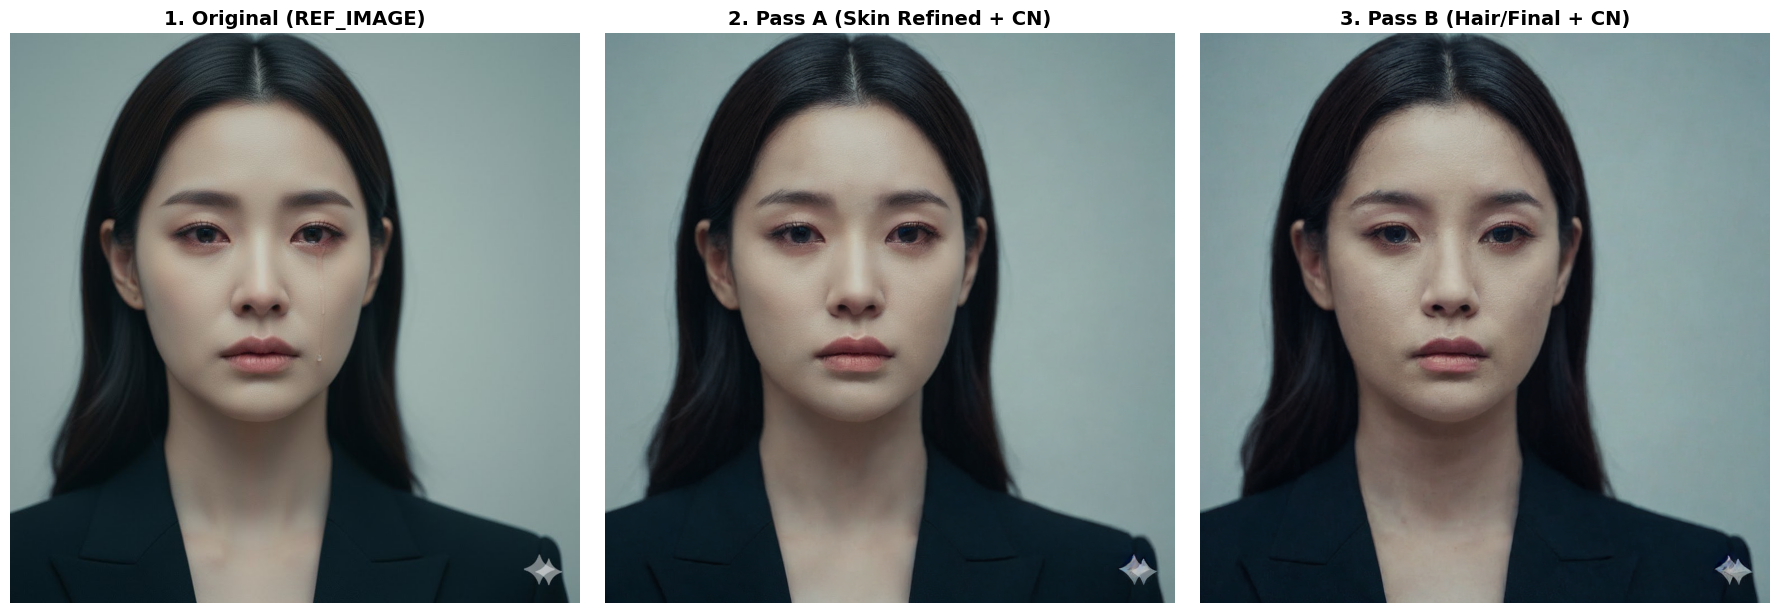

In [32]:
# @title [delete] 7. EDIT DA VÀ TÓC (Refinement I2I - Sử dụng ControlNet)

# ============================================================
# 💎 TWO-PASS SAFE I2I REFINEMENT (SKIN + HAIR/BEARD)
# ============================================================

from PIL import Image
import cv2
import numpy as np
import os
import torch
from IPython.display import display
import matplotlib.pyplot as plt

# --- CONFIG & PATHS ---
OUT_DIR = "/content/mask"
os.makedirs(OUT_DIR, exist_ok=True)
print("Output directory:", OUT_DIR)

# Paths cho masks
FINAL_MASK_PATH = "/content/mask/final_mask.png"
SAM_MASK_PATH   = "/content/mask/sam_mask.png"
FACE_MASK_PATH  = "/content/mask/face_skin_mask.png"
HAIR_MASK_PATH  = os.path.join(OUT_DIR, "mask_hair.png")

# Path cho Canny Edge Map (Cần chạy Cell 6 để tạo ra file này)
CANNY_MAP_PATH = "/mnt/data/canny_map.png"

# --- 1) LOAD ẢNH ĐẦU VÀO: CHẮC CHẮN LÀ REF_IMAGE ---
ref_image_from_global = globals().get('REF_IMAGE')
REF_IMAGE_PATH_FALLBACK = os.path.join("/mnt/data", "temp_ref_image_for_mask.png")

# Logic tải ảnh gốc
if ref_image_from_global is None:
    if os.path.exists(REF_IMAGE_PATH_FALLBACK):
        try:
            init_img = Image.open(REF_IMAGE_PATH_FALLBACK).convert("RGB")
            print(f"-> Đã tải lại REF_IMAGE từ file: {REF_IMAGE_PATH_FALLBACK}")
        except Exception as e:
            raise RuntimeError(f"Lỗi tải REF_IMAGE từ file: {e}. Vui lòng chạy Cell 2 để upload ảnh.")
    else:
        raise RuntimeError("Lỗi: Không tìm thấy REF_IMAGE. Vui lòng chạy Cell 2 để upload ảnh.")
else:
    init_img = ref_image_from_global.convert("RGB")
    print("-> Đã lấy REF_IMAGE từ biến global.")

W, H = init_img.size

# --- 2) CHUẨN BỊ MASK DA (SKIN MASK) ---
if os.path.exists(FINAL_MASK_PATH):
    mask_skin = Image.open(FINAL_MASK_PATH).convert("L").resize((W,H))
    print("Using final_mask:", FINAL_MASK_PATH)
else:
    raise FileNotFoundError("Lỗi: Không tìm thấy Final Mask. Vui lòng chạy Cell 6b trước.")
mask_skin.save(os.path.join(OUT_DIR, "used_final_skin_mask.png"))

# --- 3) CHUẨN BỊ MASK TÓC/RÂU (HAIR/BEARD MASK) ---
if os.path.exists(SAM_MASK_PATH) and os.path.exists(FACE_MASK_PATH):
    try:
        sam = cv2.imread(SAM_MASK_PATH, cv2.IMREAD_GRAYSCALE)
        face = cv2.imread(FACE_MASK_PATH, cv2.IMREAD_GRAYSCALE)
        sam = cv2.resize(sam, (W,H), interpolation=cv2.INTER_LINEAR)
        face = cv2.resize(face, (W,H), interpolation=cv2.INTER_LINEAR)
        face_inv = cv2.bitwise_not(face)
        hair_np = cv2.bitwise_and(sam, face_inv)
        k_open = max(5, int(min(W,H)/300))
        hair_np = cv2.morphologyEx(hair_np, cv2.MORPH_OPEN, np.ones((k_open,k_open), np.uint8))
        hair_np = cv2.GaussianBlur(hair_np, (11,11), 0)
        mask_hair = Image.fromarray(hair_np).convert("L")
        mask_hair.save(HAIR_MASK_PATH)
        print("Auto-created hair mask saved:", HAIR_MASK_PATH)
    except Exception as e:
        print(f"Lỗi tạo hair mask tự động: {e}. Dùng fallback.")
        mask_hair = Image.fromarray(np.zeros((H,W), np.uint8)).convert("L")
else:
    mask_hair = Image.fromarray(np.zeros((H,W), np.uint8)).convert("L")
    print("⚠️ Thiếu SAM/FACE mask. Dùng hair mask trống.")
mask_hair.save(os.path.join(OUT_DIR, "used_mask_hair.png"))


# --- 4) CHUẨN BỊ PIPELINE, CANNY IMAGE VÀ SEED ---
# LẤY PIPELINE TỪ GLOBAL (ĐÃ ĐƯỢC LOAD TỪ CELL 5B)
i2i_pipe = globals().get('canny_pipe')
CANNY_ACTIVE = (i2i_pipe is not None) and (globals().get('canny_controlnet') is not None)

if i2i_pipe is None:
    i2i_pipe = globals().get('i2i_pipe') or globals().get('pipe') or globals().get('pipe_img2img')
    if i2i_pipe is None:
        raise RuntimeError("❌ Không tìm thấy pipeline i2i nào. Vui lòng chạy Cell 1 và Cell 5b.")

# Cấu hình device cho pipeline (nếu chưa có)
device = "cuda" if torch.cuda.is_available() else "cpu"
i2i_pipe.to(device)

print(f"Pipeline sử dụng: {'ControlNet Canny' if CANNY_ACTIVE else 'I2I Thường'}")

# TẢI CANNY IMAGE NẾU CẦN
canny_image = None
if CANNY_ACTIVE:
    if os.path.exists(CANNY_MAP_PATH):
        canny_image = Image.open(CANNY_MAP_PATH).convert("RGB").resize((W, H))
        print(f"-> Đã tải Canny Map từ: {CANNY_MAP_PATH}")
    else:
        print(f"⚠️ Lỗi: Không tìm thấy Canny Map tại {CANNY_MAP_PATH}. Vô hiệu hóa ControlNet.")
        CANNY_ACTIVE = False


# Seeds
gen_seed = globals().get('SEED_IMAGE') if 'SEED_IMAGE' in globals() else 707
generator = torch.Generator(device).manual_seed(int(gen_seed))




# ============================================================
# PASS A: SKIN MICROTEXTURE REFINEMENT
# ============================================================
print("\nRunning Pass A (skin microtexture refinement)...")

cn_args_a = {}
if CANNY_ACTIVE:
    cn_args_a['controlnet_conditioning_image'] = canny_image
    cn_args_a['controlnet_conditioning_scale'] = CN_SCALE_A
    print(f"-> Pass A sử dụng ControlNet (Scale={CN_SCALE_A})")

out_a = i2i_pipe(
    prompt=PASS_A_PROMPT,
    negative_prompt=PASS_A_NEG,
    image=init_img,
    mask_image=mask_skin,
    strength=STRENGTH_A,
    guidance_scale=CFG_A,
    num_inference_steps=STEPS_A,
    generator=generator,
    **cn_args_a
).images[0]

out_a_path = os.path.join(OUT_DIR, "ace_passA_skin_refined.png")
out_a.save(out_a_path)
print(f"✅ Saved Pass A (Strength={STRENGTH_A}) ->", out_a_path)

# ============================================================
# PASS B: HAIR & BEARD REFINEMENT
# ============================================================
generator = torch.Generator(device).manual_seed(int(gen_seed)+1)

print("\nRunning Pass B (hair & beard refinement)...")

cn_args_b = {}
if CANNY_ACTIVE:
    cn_args_b['controlnet_conditioning_image'] = canny_image
    cn_args_b['controlnet_conditioning_scale'] = CN_SCALE_B
    print(f"-> Pass B sử dụng ControlNet (Scale={CN_SCALE_B})")

out_b = i2i_pipe(
    prompt=PASS_B_PROMPT,
    negative_prompt=PASS_A_NEG,
    image=out_a,
    mask_image=mask_hair,
    strength=STRENGTH_B,
    guidance_scale=CFG_B,
    num_inference_steps=STEPS_B,
    generator=generator,
    **cn_args_b
).images[0]

out_b_path = os.path.join(OUT_DIR, "ace_passB_hair_beard_final.png")
out_b.save(out_b_path)
print(f"✅ Saved Pass B (Strength={STRENGTH_B}) ->", out_b_path)

# --- Show final result ---
print("\n--- HOÀN TẤT CELL 7: Tinh chỉnh I2I 2 bước thành công ---")
globals()['FINAL_IMAGE_REFINED_I2I'] = out_b

# --- HIỂN THỊ CẢ 3 HÌNH TỐI GIẢN ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ["1. Original (REF_IMAGE)", "2. Pass A (Skin Refined)", "3. Pass B (Hair/Final)"]
if CANNY_ACTIVE:
    titles = ["1. Original (REF_IMAGE)", "2. Pass A (Skin Refined + CN)", "3. Pass B (Hair/Final + CN)"]

images_to_show = [init_img, out_a, out_b]

for i, img_data in enumerate(images_to_show):
    ax = axes[i]
    ax.imshow(img_data)
    ax.set_title(titles[i], fontsize=14, weight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n")